In [366]:
import pandas as pd
import numpy as np
import re
import random

import datetime
from datetime import datetime, timedelta
from textblob import TextBlob
from afinn import Afinn
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import spacy
import shap, time


from collections import OrderedDict
import math 
from mpl_toolkits.mplot3d import Axes3D
from pandas_datareader.data import DataReader
import pandas_market_calendars as mcal
from scipy.sparse import hstack

%matplotlib inline

In [ ]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

from collections import Counter
from wordcloud import WordCloud, STOPWORDS

from pandas.plotting import parallel_coordinates
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import path
from PIL import Image
import os


import sys
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

In [ ]:
# NLTK 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist


In [ ]:
#import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.tree         import DecisionTreeClassifier
from sklearn.ensemble     import BaggingClassifier
from sklearn.ensemble     import AdaBoostClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier

In [404]:
matplotlib.style.use('ggplot')

In [2]:
apple_clean = pd.read_pickle('../../Processed Data/Amazon Product AAPL/aapl_df.pkl')

In [9]:
apple_clean

,product_title,review_body,review_date,unique_products,product_tags,stars
14,apple iphone 6 gold 64 gb sprint,Great products great prices,2015-08-31,iphone 6,"[ipad mini retina , macbook air, iphone 6, mac...",5
28,apple iphone 6 new locked,Works great,2015-08-31,iphone 6,"[ipad mini retina , macbook air, iphone 6, mac...",5
63,apple iphone 6 16 gb at t silver,Purchased this phone from the Apple Store and ...,2015-08-30,iphone 6,"[ipad mini retina , macbook air, iphone 6, mac...",4
64,apple iphone 6 plus new locked,It arrived on time and everything was just as ...,2015-08-30,iphone 6,"[ipad mini retina , macbook air, iphone 6, mac...",5
68,apple iphone 6 a1549 64gb gold smartphone t mo...,Exactly what I wanted,2015-08-30,iphone 6,"[ipad mini retina , macbook air, iphone 6, mac...",5
...,...,...,...,...,...,...
59513,apple iphone 7 plus 32gb silver fully unlocked...,one word awesome,2017-03-11,iphone 7,"[apple pencil, iphone 7, earpods with lightnin...",5
59529,apple iphone 7 plus 32gb silver fully unlocked...,The worst phone ever I got it today and I am g...,2017-03-27,iphone 7,"[iphone 7, earpods with lightning connector, i...",1
59609,apple pencil for ipad pro 2nd generation seria...,Muy bueno,2019-10-05,ipad,"[iphone xr, ipad air, ipad mini, iphone 11, ipad]",5
59611,apple pencil for ipad pro 2nd generation seria...,Great product like new,2019-10-13,ipad,"[iphone xr, ipad air, ipad mini, iphone 11, ipad]",5


In [8]:
df = apple_clean[['product_title', 'review_body', 'review_date', 'unique_products','stars']]
df = df.groupby(['review_date'], as_index=False).agg({'stars':'sum',
                                                  'product_title':lambda x: ','.join(x), 
                                                   'review_body':lambda x: ','.join(x),
                                                   'unique_products':lambda x: ','.join(x)      
                                                       })

In [11]:
df5 = pd.DataFrame(apple_clean['review_date'].value_counts().reset_index().values, columns=["Date", "Count"])
dict_date = pd.Series(df5['Count'].values,index=df5['Date']).to_dict()
df['review_counts'] = df['review_date'].map(dict_date)

In [12]:
df

,review_date,stars,product_title,review_body,unique_products,review_counts
0,2013-04-16,16,apple earpods with remote and mic certified re...,this is terrible I ordered this months ago and...,"apple earpods,apple earpods,iphone 5,apple ear...",5
1,2013-04-17,63,apple earpods with remote and mic certified re...,The EarPods are fine they have great sound and...,"apple earpods,apple earpods,apple earpods,ipho...",15
2,2013-04-18,41,apple earpods with remote and mic certified re...,these headphones are much more comfortable the...,"apple earpods,apple earpods,iphone 5,iphone 4s...",10
3,2013-04-19,35,apple earpods with remote and mic certified re...,Love how Apple considered runners for these he...,"apple earpods,apple earpods,apple earpods,ipho...",8
4,2013-04-20,15,"apple iphone 5 16 gb unlocked white,apple earp...",I chose it because it has a great screen It ha...,"iphone 5,apple earpods,apple earpods,apple ear...",4
...,...,...,...,...,...,...
1758,2019-10-25,44,new apple ipad 10 2 inch wi fi 32gb space gray...,"Love my iPad,I got the phone yesterday and tri...","ipad,iphone xr,iphone xr,iphone xr,iphone xr,i...",11
1759,2019-10-26,26,apple iphone xr 64gb coral fully unlocked rene...,Horrible experience Had the phone less than a ...,"iphone xr,ipad,ipad,iphone xr,ipad,ipad",6
1760,2019-10-27,42,new apple ipad 10 2 inch wi fi 32gb space gray...,This iPad th generation GB tablet replaces an ...,"ipad,ipad,ipad,ipad,ipad,ipad,ipad,ipad,ipad,ipad",10
1761,2019-10-28,47,apple iphone xr 64gb coral fully unlocked rene...,"Its actually great no regrets thanks,Like,ios ...","iphone xr,ipad,ipad,ipad,ipad,ipad,ipad,ipad,i...",10


## Get Labels

1. Get labels using API
2. for every date, get the price of today's and yesterday's date
3. for every date, get the daily returns of by log(today price/yesterday's date)
4. get the start week date and previous week date for each review date
5. get the start week price and the previous week price
6. aggregate the dataset in a weekly basis
7. get the weekly returns by summing up daily log returns 
8. get the labels where label = 1 if weekly returns >= 0 and label = -1 if weekly returns < 0 

We will be aggregating data in a weekly basis. We hypothesise that reviews on that day itself will have little effect on the stock price for tomorrow as it takes time for the reviews to take effect on the stock prices/company performance.

In [13]:
#Get Labels
yahoo_url = "https://finance.yahoo.com/quote/%5EDJI/components/"
djia_table = pd.read_html(yahoo_url, header=0, index_col=0)[0]
djia_table = djia_table.reset_index()

wiki_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
cik_df = pd.read_html(wiki_url,header=0,index_col=0)[0]
cik_df['GICS Sector'] = cik_df['GICS Sector'].astype("category")
cik_df['GICS Sub Industry'] = cik_df['GICS Sector'].astype("category")
cik_df = cik_df.reset_index()

cik_df = cik_df[cik_df["Symbol"].isin(djia_table.Symbol)].reset_index().drop(["index"], axis=1)
cik_df.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrials,"St. Paul, Minnesota",1976-08-09,66740,1902
1,AXP,American Express Co,reports,Financials,Financials,"New York, New York",1976-06-30,4962,1850
2,AAPL,Apple Inc.,reports,Information Technology,Information Technology,"Cupertino, California",1982-11-30,320193,1977
3,BA,Boeing Company,reports,Industrials,Industrials,"Chicago, Illinois",NaN,12927,1916
4,CAT,Caterpillar Inc.,reports,Industrials,Industrials,"Deerfield, Illinois",NaN,18230,1925


In [14]:
def get_data_for_multiple_stocks(tickers, start_date, end_date):
    '''
    Obtain stocks information (Date, OHLC, Volume and Adjusted Close). 
    Uses Pandas DataReader to make an API Call to Yahoo Finance and download the data directly.
    Computes other values - Log Return and Arithmetic Return.
    
    Input: List of Stock Tickers
    Output: A dictionary of dataframes for each stock
    '''
    stocks = dict()
    for ticker in tickers:
        s = DataReader(ticker, 'yahoo', start_date, end_date)
        s.insert(0, "Ticker", ticker)  #insert ticker column so you can reference better later
        s['Date'] = pd.to_datetime(s.index) #useful for transformation later
        s['Prev Adj Close'] = s['Adj Close'].shift(1)
        s['Log Return'] = np.log(s['Adj Close']/s['Prev Adj Close'])
        s['Return'] = (s['Adj Close']/s['Prev Adj Close']-1)
        s = s.reset_index(drop=True)
        
        cols = list(s.columns.values) # re-arrange columns
        cols.remove("Date")
        s = s[["Date"] + cols]
        s["Date"] = pd.to_datetime(s["Date"])
        s = s.set_index("Date")
        
        stocks[ticker] = s
        
    return stocks

/anaconda3/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [15]:
stock_data = get_data_for_multiple_stocks(["AAPL"], "2010-01-01", "2020-01-01")

In [17]:
nyse = mcal.get_calendar('NYSE')
nyse_holidays = nyse.holidays().holidays

In [18]:
#get the price of the stock 
def get_price(ticker,start_date,end_date,market_open=False):
    '''
    For the ticker of start and end date, get the Adj prices
    '''
    start_date = start_date.date()
    end_date = end_date.date()

    try:
        if market_open == False:
            price = stock_data[ticker].loc[start_date:end_date,"Adj Close"].mean()
        else:
            price = stock_data[ticker].loc[start_date:end_date,"Open"].mean()
    except (KeyError,IndexError):
        price = np.nan
    return price


In [19]:
#check whether the day is a weekday 
def weekday_check(date):  
    while date.isoweekday() > 5 or date.date() in nyse_holidays:
        date = date + timedelta(days=-1)
    return date

In [20]:
def weekday_check_start_date(date):
    while date.isoweekday() > 5 or date.date() in nyse_holidays:
        date = date + timedelta(days=-1)
    return date

In [21]:
def weekday_check_end_date(date):
    while date.isoweekday() > 5 or date.date() in nyse_holidays:
        date = date + timedelta(days=1)
    
    return date

In [22]:
def get_start_end_dates(row):
    '''
    Get start week date and end week date based on the review date
    '''
    release_date = row["review_date"]
    
    this_week = weekday_check_start_date(release_date)
    last_week = weekday_check_end_date(release_date + timedelta(days=-7))
    
    return (this_week, last_week)

In [23]:
def get_start_end_dates_daily(row):
    '''
    Get the today and yesterday date (where market is open)
    '''
    release_date = row["review_date"]
    
    today = weekday_check_start_date(release_date)
    yest = weekday_check_end_date(release_date + timedelta(days=-1))
    
    return (today, yest)

In [24]:
def get_start_end_prices(row):
    '''
    Get the price of start week and prev week
    '''
    SW = row["start week"]
    PW = row["prev week"]
    #ticker = row["ticker"]
    
    price_SW = get_price('AAPL', SW, SW, market_open=False)
    price_PW = get_price('AAPL', PW, PW, market_open=False)
    return (price_SW, price_PW)

In [25]:
def get_start_end_prices_daily(row):
    '''
    Get the price of today and yesterday
    '''
    today = row["today"]
    yest = row["yest"]
    #ticker = row["ticker"]
    
    price_today = get_price('AAPL', today, today, market_open=False)
    price_yest = get_price('AAPL', yest, yest, market_open=False)
    return (price_today, price_yest)

In [26]:
df

,review_date,stars,product_title,review_body,unique_products,review_counts
0,2013-04-16,16,apple earpods with remote and mic certified re...,this is terrible I ordered this months ago and...,"apple earpods,apple earpods,iphone 5,apple ear...",5
1,2013-04-17,63,apple earpods with remote and mic certified re...,The EarPods are fine they have great sound and...,"apple earpods,apple earpods,apple earpods,ipho...",15
2,2013-04-18,41,apple earpods with remote and mic certified re...,these headphones are much more comfortable the...,"apple earpods,apple earpods,iphone 5,iphone 4s...",10
3,2013-04-19,35,apple earpods with remote and mic certified re...,Love how Apple considered runners for these he...,"apple earpods,apple earpods,apple earpods,ipho...",8
4,2013-04-20,15,"apple iphone 5 16 gb unlocked white,apple earp...",I chose it because it has a great screen It ha...,"iphone 5,apple earpods,apple earpods,apple ear...",4
...,...,...,...,...,...,...
1758,2019-10-25,44,new apple ipad 10 2 inch wi fi 32gb space gray...,"Love my iPad,I got the phone yesterday and tri...","ipad,iphone xr,iphone xr,iphone xr,iphone xr,i...",11
1759,2019-10-26,26,apple iphone xr 64gb coral fully unlocked rene...,Horrible experience Had the phone less than a ...,"iphone xr,ipad,ipad,iphone xr,ipad,ipad",6
1760,2019-10-27,42,new apple ipad 10 2 inch wi fi 32gb space gray...,This iPad th generation GB tablet replaces an ...,"ipad,ipad,ipad,ipad,ipad,ipad,ipad,ipad,ipad,ipad",10
1761,2019-10-28,47,apple iphone xr 64gb coral fully unlocked rene...,"Its actually great no regrets thanks,Like,ios ...","iphone xr,ipad,ipad,ipad,ipad,ipad,ipad,ipad,i...",10


In [27]:
#get today and yesterday prices
#get the returns by log(today's price)/log(yesterday's price)
#get labels where labels = 1 if log_returns >= 0 else labels = -1 if log_returns < 0

df['today'], df["yest"] = zip(*df.apply(get_start_end_dates_daily, axis=1))
df['today'], df["yest"] = zip(*df.apply(get_start_end_prices_daily, axis=1))
df["log_returns"] = df.apply(lambda row: math.log(row["today"]/row["yest"]), axis=1)
df["labels"] = df["log_returns"].map(lambda x : 1 if x>=0 else -1)

In [28]:
#get start week and prev week prices
#get historical labels

df['start week'], df["prev week"] = zip(*df.apply(get_start_end_dates, axis=1))
df['start week'], df["prev week"] = zip(*df.apply(get_start_end_prices, axis=1))
df["hist_returns"] = df.apply(lambda row: math.log(row["start week"]/row["prev week"]), axis=1)


In [29]:
#get the start week date 
df['Start_week'] = df['review_date'].apply(lambda x: x - timedelta(days=x.weekday()))

In [304]:
df.columns

Index(['word', 'topic_id', 'importance', 'word_count'], dtype='object')

In [32]:
df_weekly = df[['Start_week','stars', 'review_body',
       'review_counts', 'log_returns', 'hist_returns']]

In [29]:
## Sum up the log returns for the week, t = start week, t7 = end week
## sum = log(t1) - log(t0) + log(t2) - log(t1)... log (t7)
## log_return = log(t7/t0)

In [34]:
#WEEKLY REVIEWS
df_weekly = df_weekly.groupby(['Start_week'], as_index=False).agg({'stars':'sum',
                                                  'review_body':lambda x: ','.join(x), 
                                                   'review_counts':'sum',
                                                   'log_returns':'sum', 
                                                    'hist_returns': 'first',
                                                       })

[<matplotlib.lines.Line2D at 0x1afdc559b0>]

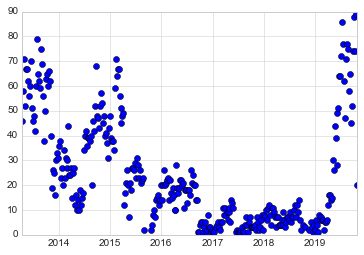

In [376]:
matplotlib.pyplot.plot_date(df_weekly['Start_week'], df_weekly['review_counts'])

In [296]:
len(df_weekly)

327

## Features for Dataset
1. Afinn scores
2. Sentiment based on Textblob
3. Sentiment based on Vadar SentimentIntensityAnalyzer
4. Stars
5. Stars Avg
6. Review counts
7. Historical Returns

In [42]:
word_tokenize = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     /Users/viennawong/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [43]:
#Lemmatize reviews using nltk
def preprocess_text_lemm(text):
    '''
    Takes in the text and process them
    
    Return cleaned tokens
    '''
    words = set(nltk.corpus.words.words())
    text = text.replace("\x90", " ").replace("\x91", " ").replace("\x92", " ").replace("\x93", " ").replace("\x94", " ").replace("\x95", " ").replace("\x96", " ").replace("\x97", " ").replace("\x98", " ").replace("\x99", " ")
    self_generated_stopwords = ["and", "the", "for", "with", "apple", "note", "with", "date", "this", "any", "it", "such", "will", "that", "shall", "are", "be", "have", "its", "not", "under", "which"]
    try:
        # Generate tokens
        tokens = word_tokenize.tokenize(text)

        filtered_tokens = []
        
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)

        # Convert to lowercase
        filtered_tokens = [t.lower() for t in filtered_tokens]

        ## Remove short words (< 3 letters)
        filtered_tokens = list(filter(lambda t: len(t) > 2, filtered_tokens))

        # Lemmatize (including the verbs!)
        filtered_tokens = list(map(lambda token: lemmatizer.lemmatize(token.lower(), pos='v'), filtered_tokens))
        
        # Remove stopwords [self-generated]
        filtered_tokens = list(filter(lambda t: t not in self_generated_stopwords, filtered_tokens))
        
        # Remove gibberish
        filtered_tokens = list(filter(lambda t: t in words, filtered_tokens))

        return filtered_tokens
    
    except Exception as e:
        raise e


In [44]:
df_weekly['review_body_lemm'] = df_weekly['review_body'].apply(preprocess_text_lemm)

In [45]:
df_weekly['review_body_lem'] = df_weekly.review_body_lemm.apply(lambda x:" ".join(x))

In [47]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    '''
    Takes in the text and number of terms and returns a plot of the frequency distribution of words
    '''
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

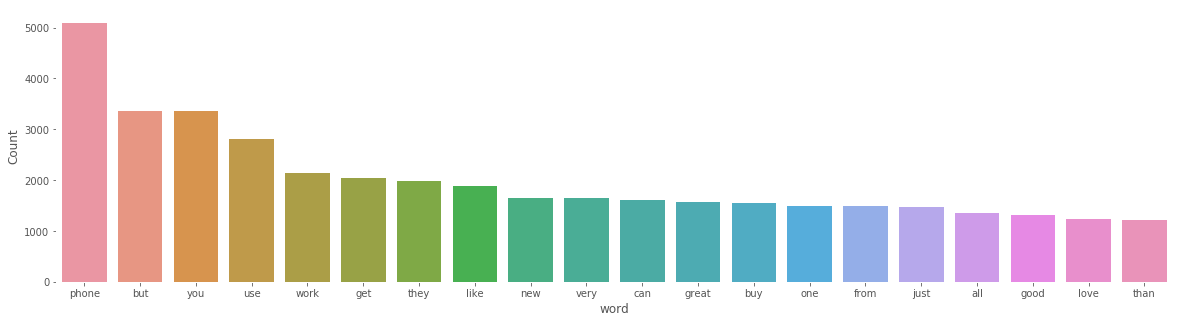

In [312]:
%matplotlib inline
freq_words(df_weekly.review_body_lem, 20)

In [50]:
# In terminal: pip install afinn
from afinn import Afinn
afinn = Afinn()

In [51]:
df_weekly['afinn_scores'] =[afinn.score(text) for text in df_weekly.review_body_lem]

In [54]:
df_weekly.head()

,Start_week,stars,review_body,review_counts,log_returns,hist_returns,review_body_lemm,review_body_lem,afinn_scores
0,2013-04-15,182,this is terrible I ordered this months ago and...,46,-0.093022,-0.001735,"[terrible, order, ago, one, side, work, questi...",terrible order ago one side work question whet...,243.0
1,2013-04-22,220,Hi I am interested in the article but I need t...,58,0.014933,-0.051763,"[interest, article, but, need, know, factory, ...",interest article but need know factory unlock ...,307.0
2,2013-04-29,280,i love my new iphone i used to have the model ...,71,0.021573,0.075930,"[love, new, use, model, but, one, far, better,...",love new use model but one far better recommen...,382.0
3,2013-05-06,213,Until now this has been the best purchase I ha...,52,-0.014245,0.068705,"[until, now, best, purchase, make, because, ph...",until now best purchase make because phone gre...,443.0
4,2013-05-13,274,I really like this phone also do not have what...,67,-0.070461,-0.006446,"[really, like, phone, also, what, problem, ver...",really like phone also what problem very good ...,509.0


In [55]:
# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    '''
    Takes in the text and return Textblob polarity sentiment
    '''
    blob = TextBlob(text)
    
    # return the polarity
    return blob.sentiment.polarity

In [56]:
# create a new DataFrame column for sentiment 
df_weekly['tb_sentiment'] = df_weekly.review_body_lem.apply(detect_sentiment)

#Sentiment is the "attitude" of the speaker:

#polarity ranges from -1 (most negative) to 1 (most positive)
#subjectivity ranges from 0 (very objective) to 1 (very subjective)

In [59]:
df_weekly['stars_avg'] = df_weekly['stars'].div(df_weekly['review_counts'], axis=0)

In [64]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
df_weekly["sentiments_vadar"] = df_weekly.review_body_lem.apply(lambda x: sid.polarity_scores(x))

/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/viennawong/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [65]:
df_weekly['sentiments_v_neg'] = ''
df_weekly['sentiments_v_neu'] = ''
df_weekly['sentiments_v_pos'] = ''
df_weekly['sentiments_v_cpd'] = ''
for index, row in df_weekly.iterrows():
    df_weekly.at[index, 'sentiments_v_neg'] = row['sentiments_vadar']['neg']
    df_weekly.at[index, 'sentiments_v_neu'] = row['sentiments_vadar']['neu']
    df_weekly.at[index, 'sentiments_v_pos'] = row['sentiments_vadar']['pos']
    df_weekly.at[index, 'sentiments_v_cpd'] = row['sentiments_vadar']['compound']

## EDA

1. Understanding the dataset using visualizations
2. Look at the correlations between features
3. Plot graphs that show the relation between different labels and the features
4. Wordcloud to understand the reviews


In [66]:
df5 = df_weekly[['Start_week','stars','review_body', 'review_counts',
       'log_returns', 'review_body_lemm', 'review_body_lem','afinn_scores',
       'tb_sentiment', 'stars_avg','hist_returns', 'sentiments_v_neg', 'sentiments_v_neu', 'sentiments_v_pos',
       'sentiments_v_cpd']]
df5['labels'] = df_weekly['log_returns'].apply(lambda x: 1 if x>=0 else -1)

In [67]:
df5["scaled_sentiment"] = (df5.tb_sentiment - np.mean(df5.tb_sentiment))/np.std(df5.tb_sentiment)

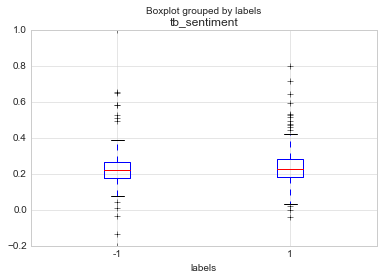

In [377]:
df5.boxplot('tb_sentiment', by='labels')

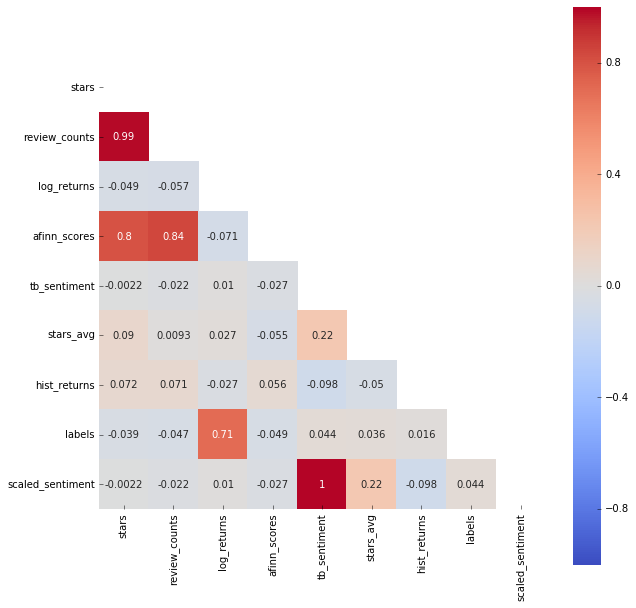

In [325]:
corr = df5.corr()
fig, ax = plt.subplots(figsize=(10,10))  
fig.patch.set_facecolor('white')
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, cmap='coolwarm', mask=mask, annot=True, vmin=-1, vmax=1, center= 0, square=True)
#YlGnBu

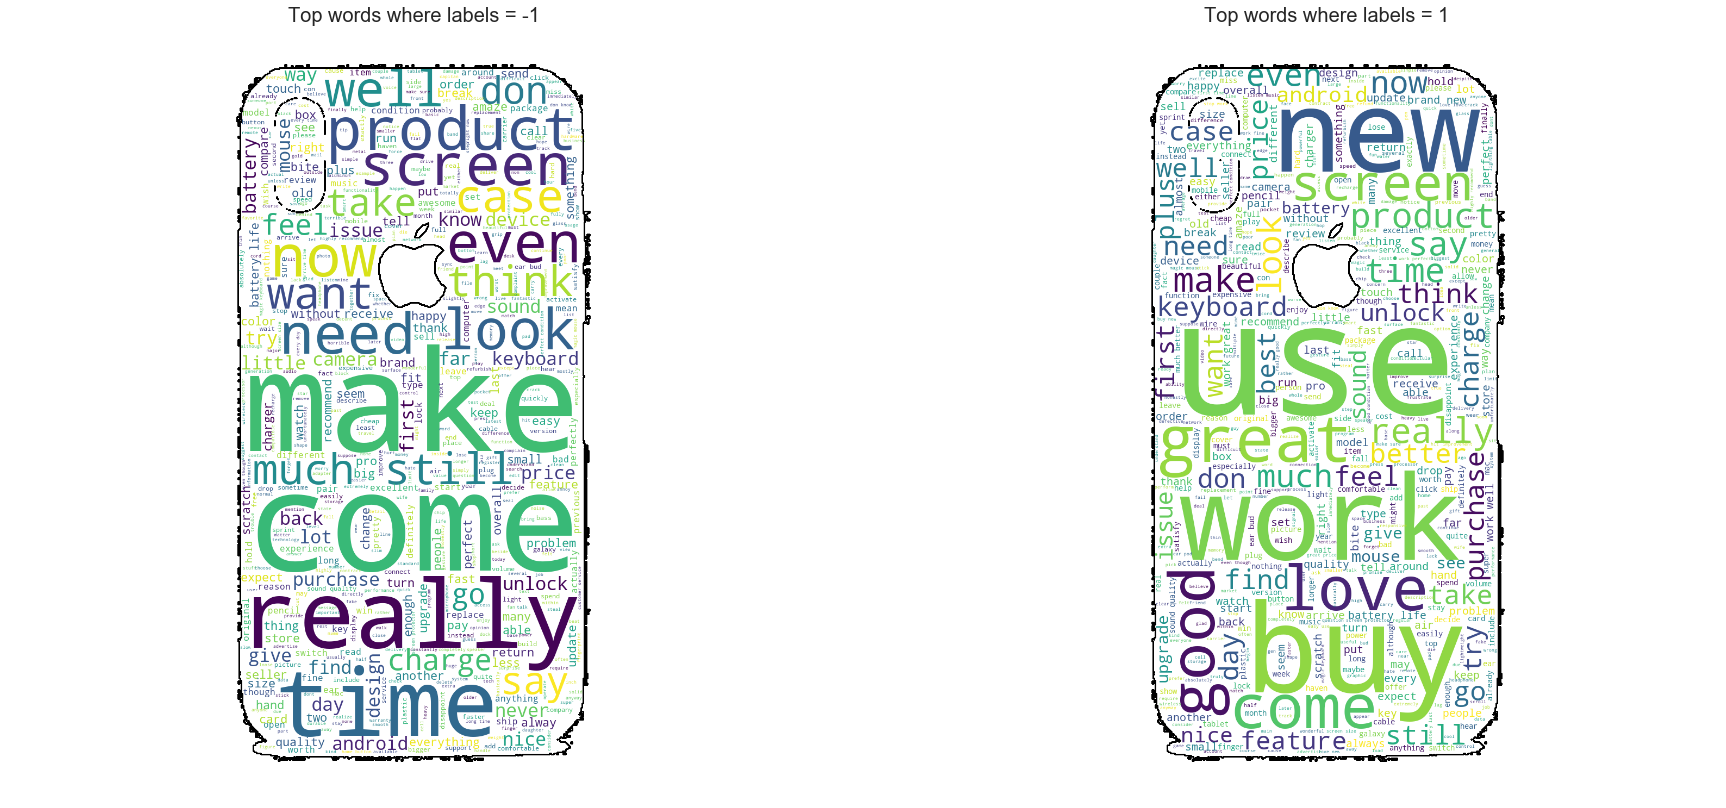

In [459]:
n_posts = 5000
q_S = ' '.join(df5[df5['labels'] == -1]['review_body_lem'].str.lower().values[:n_posts])
q_I = ' '.join(df5[df5['labels'] == 1]['review_body_lem'].str.lower().values[:n_posts])

#stopwords = set(STOPWORDS) 

wordcloud_S = WordCloud(max_font_size=None, stopwords=stopwords,scale = 2, background_color="white",
                        mask=amazon_mask, max_words=1000, contour_width=3).generate(q_S)
wordcloud_I = WordCloud(max_font_size=None, stopwords=stopwords,scale = 2, background_color="white",
                        mask=amazon_mask, max_words=1000, contour_width=3).generate(q_I)

fig, ax = plt.subplots(1,2, figsize=(30, 15))
ax[0].imshow(wordcloud_S)
ax[0].set_title('Top words where labels = -1',fontsize = 20)
ax[0].axis("off")

ax[1].imshow(wordcloud_I)
ax[1].set_title('Top words where labels = 1',fontsize = 20)
ax[1].axis("off")

plt.show()

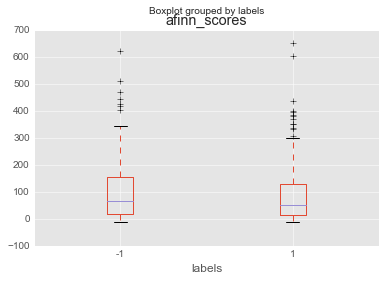

In [451]:
df5.boxplot('afinn_scores', by='labels')

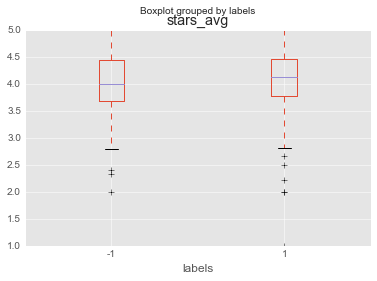

In [429]:
df5.boxplot('stars_avg', by='labels')

In [295]:
df5.corr()

,stars,review_counts,log_returns,afinn_scores,tb_sentiment,stars_avg,hist_returns,labels,scaled_sentiment
stars,1.000000,0.990509,-0.048852,0.798112,-0.002205,0.089589,0.072026,-0.039480,-0.002205
review_counts,0.990509,1.000000,-0.057140,0.836845,-0.021679,0.009346,0.071185,-0.047365,-0.021679
log_returns,-0.048852,-0.057140,1.000000,-0.071143,0.010291,0.026619,-0.027028,0.709507,0.010291
afinn_scores,0.798112,0.836845,-0.071143,1.000000,-0.027331,-0.055002,0.055700,-0.049294,-0.027331
tb_sentiment,-0.002205,-0.021679,0.010291,-0.027331,1.000000,0.223181,-0.097949,0.044307,1.000000
stars_avg,0.089589,0.009346,0.026619,-0.055002,0.223181,1.000000,-0.049769,0.035891,0.223181
hist_returns,0.072026,0.071185,-0.027028,0.055700,-0.097949,-0.049769,1.000000,0.016418,-0.097949
labels,-0.039480,-0.047365,0.709507,-0.049294,0.044307,0.035891,0.016418,1.000000,0.044307
scaled_sentiment,-0.002205,-0.021679,0.010291,-0.027331,1.000000,0.223181,-0.097949,0.044307,1.000000


In [184]:
temp = df5.copy()
temp['year'] = temp['Start_week'].apply(lambda x: x.year)

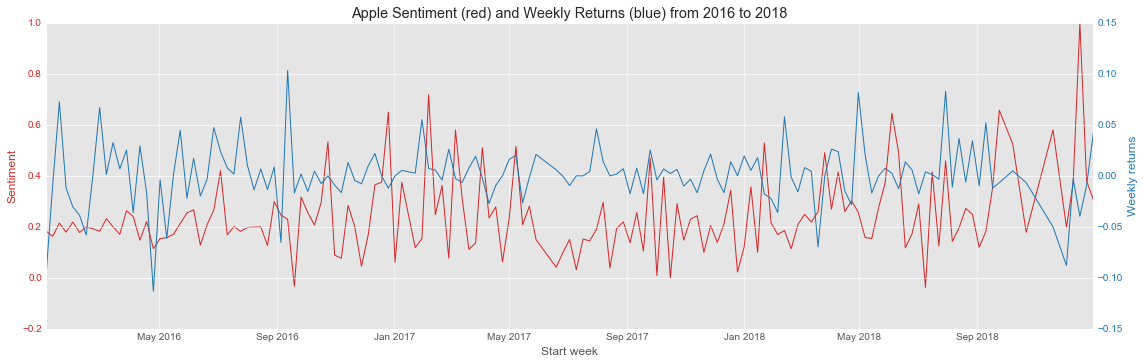

In [430]:
ntemp = temp[(temp['year'] == 2016) | (temp['year'] == 2017) | (temp['year'] == 2018)]

## Plot textblob sentiment against returns (weekly)
fig, ax1 = plt.subplots(figsize=(16,5))
color = 'tab:red'
ax1.set_xlabel('Start week')
ax1.set_ylabel('Sentiment', color=color)
ax1.plot(ntemp ["Start_week"].dt.date.tolist(), ntemp ['tb_sentiment'], color=color)
#plt.xticks(np.arange(1, 53, 1))
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Weekly returns', color=color)  # we already handled the x-label with ax1
ax2.plot(ntemp ["Start_week"].dt.date.tolist(), ntemp['log_returns'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Apple Sentiment (red) and Weekly Returns (blue) from 2016 to 2018")
plt.show()


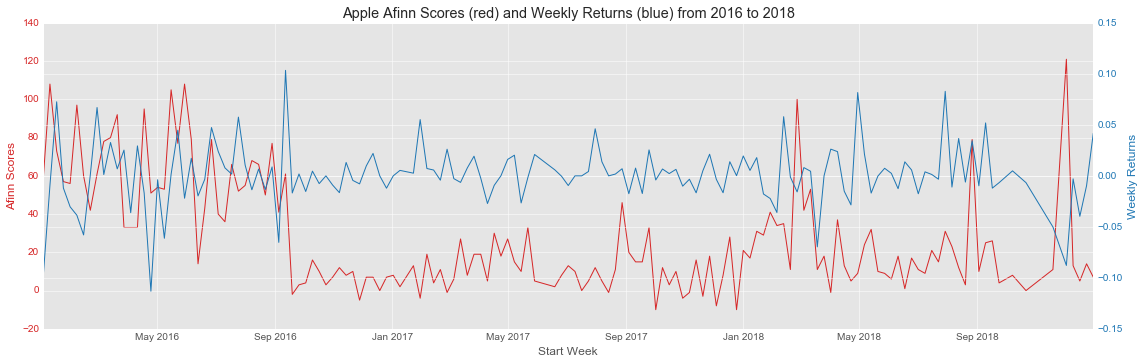

In [431]:
ntemp = temp[(temp['year'] == 2016) | (temp['year'] == 2017) | (temp['year'] == 2018)]

## Plot Afinn scores against returns (weekly)
fig, ax1 = plt.subplots(figsize=(16,5))
color = 'tab:red'
ax1.set_xlabel('Start Week')
ax1.set_ylabel('Afinn Scores', color=color)
ax1.plot(ntemp ["Start_week"].dt.date.tolist(), ntemp ['afinn_scores'], color=color)
#plt.xticks(np.arange(1, 53, 1))
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Weekly Returns', color=color)  # we already handled the x-label with ax1
ax2.plot(ntemp ["Start_week"].dt.date.tolist(), ntemp['log_returns'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Apple Afinn Scores (red) and Weekly Returns (blue) from 2016 to 2018")
plt.show()


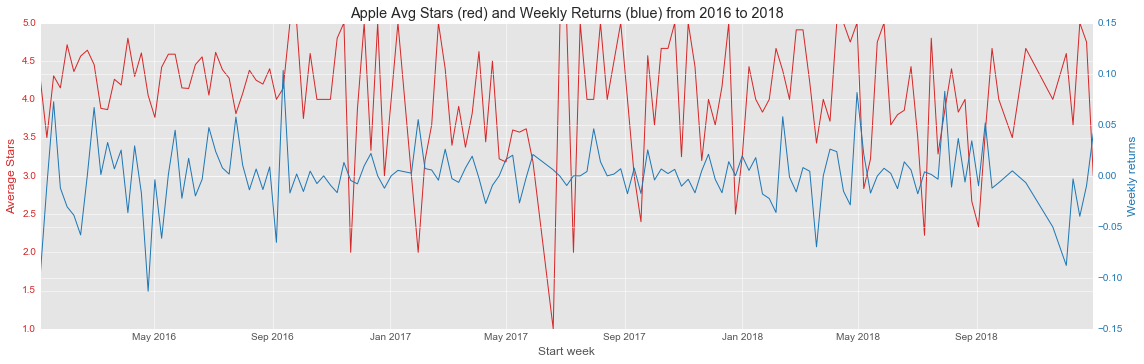

In [432]:
ntemp = temp[(temp['year'] == 2016) | (temp['year'] == 2017) | (temp['year'] == 2018)]

## Plot Average Stars against returns (weekly)
fig, ax1 = plt.subplots(figsize=(16,5))
color = 'tab:red'
ax1.set_xlabel('Start week')
ax1.set_ylabel('Average Stars', color=color)
ax1.plot(ntemp ["Start_week"].dt.date.tolist(), ntemp ['stars_avg'], color=color)
#plt.xticks(np.arange(1, 53, 1))
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Weekly returns', color=color)  # we already handled the x-label with ax1
ax2.plot(ntemp ["Start_week"].dt.date.tolist(), ntemp['log_returns'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Apple Avg Stars (red) and Weekly Returns (blue) from 2016 to 2018")
plt.show()


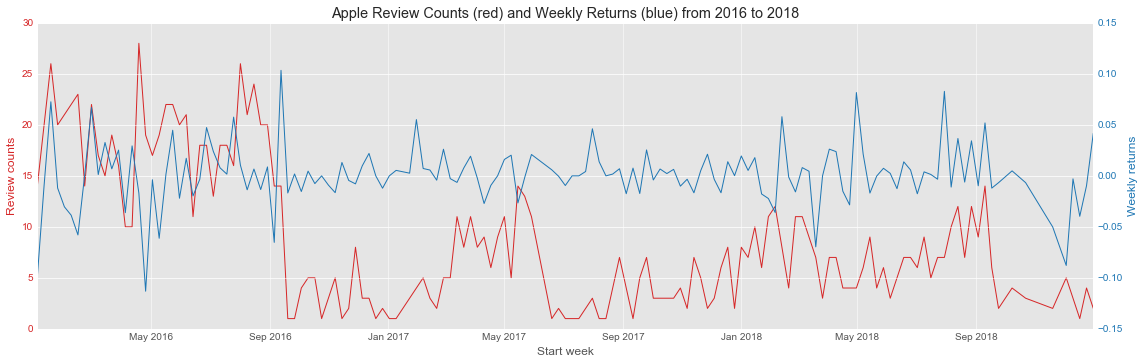

In [433]:
ntemp = temp[(temp['year'] == 2016) | (temp['year'] == 2017) | (temp['year'] == 2018)]

## Plot review counts against returns (weekly)
fig, ax1 = plt.subplots(figsize=(16,5))
color = 'tab:red'
ax1.set_xlabel('Start week')
ax1.set_ylabel('Review counts', color=color)
ax1.plot(ntemp ["Start_week"].dt.date.tolist(), ntemp ['review_counts'], color=color)
#plt.xticks(np.arange(1, 53, 1))
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Weekly returns', color=color)  # we already handled the x-label with ax1
ax2.plot(ntemp ["Start_week"].dt.date.tolist(), ntemp['log_returns'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Apple Review Counts (red) and Weekly Returns (blue) from 2016 to 2018")
plt.show()


[<matplotlib.lines.Line2D at 0x1af8487550>]

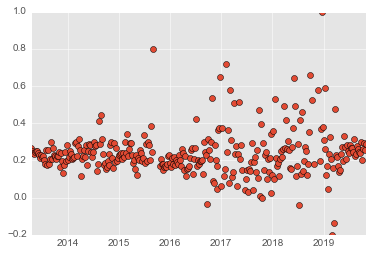

In [434]:
matplotlib.pyplot.plot_date(df5['Start_week'], df5['tb_sentiment'])

[<matplotlib.lines.Line2D at 0x1b00e025f8>]

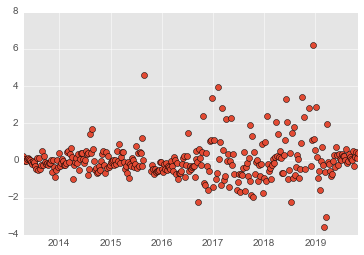

In [435]:
matplotlib.pyplot.plot_date(df5['Start_week'], df5['scaled_sentiment'])

In [82]:
df5.columns

Index(['Start_week', 'stars', 'review_body', 'review_counts', 'log_returns',
       'review_body_lemm', 'review_body_lem', 'afinn_scores', 'tb_sentiment',
       'stars_avg', 'hist_returns', 'sentiments_v_neg', 'sentiments_v_neu',
       'sentiments_v_pos', 'sentiments_v_cpd', 'labels', 'scaled_sentiment'],
      dtype='object')

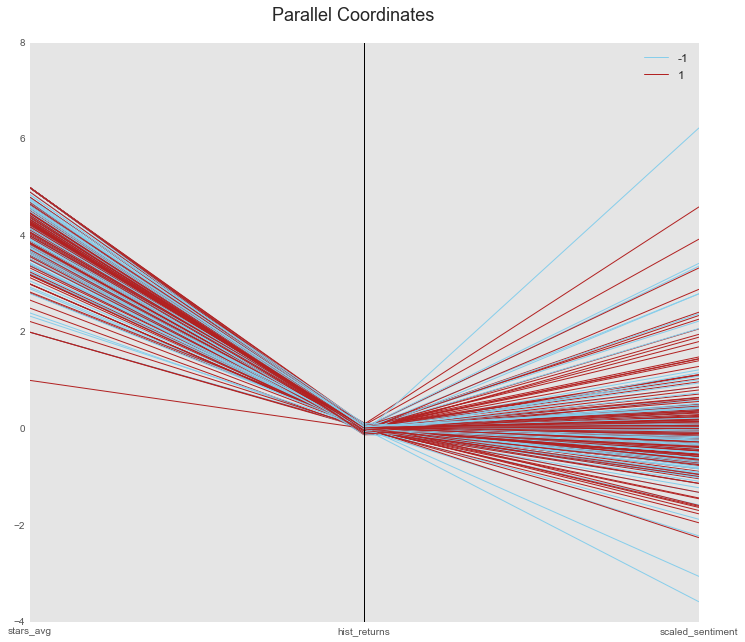

In [436]:
fig = plt.figure(figsize = (12, 10))
title = fig.suptitle("Parallel Coordinates", fontsize=18)
fig.subplots_adjust(top=0.93, wspace=0)

new_cols = ['stars_avg', 'hist_returns', 'labels', 'scaled_sentiment']
pc = parallel_coordinates(df5[new_cols], 'labels', color=('skyblue', 'firebrick'))

Text(0.5,1.05,'Sentiments - Log Returns')

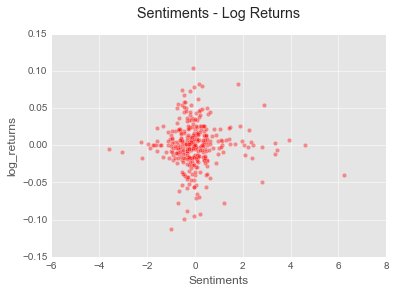

In [405]:
plt.scatter(df5['scaled_sentiment'], 
            df5['log_returns'],
            alpha=0.4, edgecolors='w', color = 'red')

plt.xlabel('Sentiments')
plt.ylabel('log_returns')
plt.title('Sentiments - Log Returns', y=1.05)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


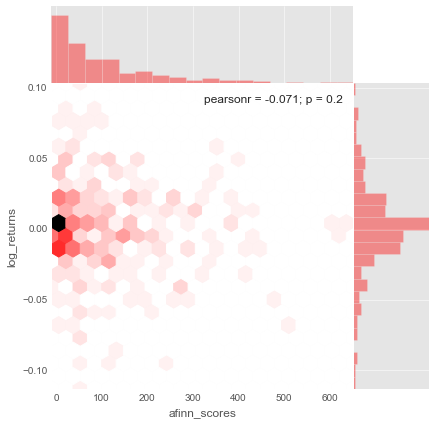

In [406]:
jp = sns.jointplot(x='afinn_scores', 
                   y='log_returns', 
                   data=df5,
                   kind='hex', # <-- Add regression and kernel density fits
                   space=0, ratio=4, color = 'red')

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


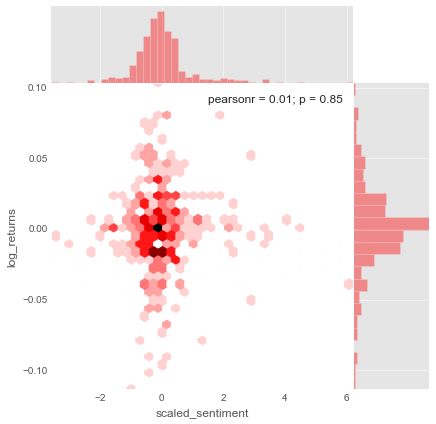

In [414]:
jp = sns.jointplot(x='scaled_sentiment', 
                   y='log_returns', 
                   data=df5,
                   kind='hex', # <-- Add regression and kernel density fits
                   space=0, ratio=4, color = 'red')

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


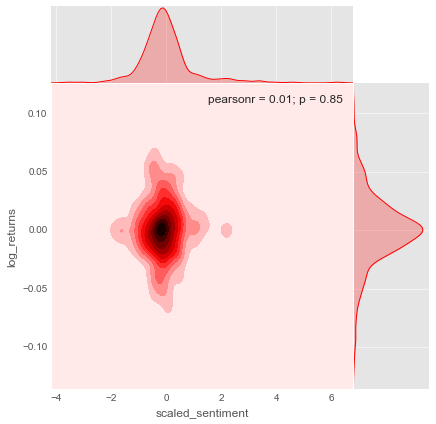

In [413]:
jp = sns.jointplot(x='scaled_sentiment', 
                   y='log_returns', 
                   data=df5,
                   kind='kde', # <-- Add regression and kernel density fits
                   space=0, ratio=4, color = 'red')

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


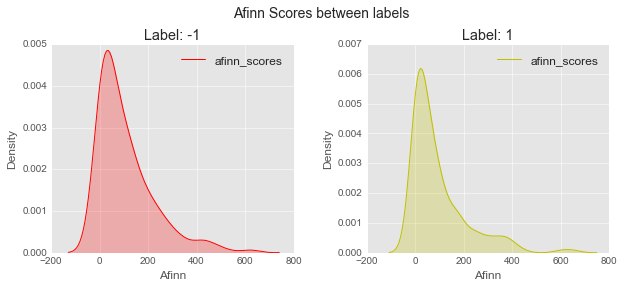

In [437]:
df_neg_1 = df5[df5['labels'] == -1]
df_pos_1 = df5[df5['labels'] == 1 ]
fig = plt.figure(figsize = (10, 4))
title = fig.suptitle("Afinn Scores between labels", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Label: -1")
ax1.set_xlabel("Afinn")
ax1.set_ylabel("Density") 
sns.kdeplot(df_neg_1['afinn_scores'], ax=ax1, shade=True, color='r')

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("Label: 1")
ax2.set_xlabel("Afinn")
ax2.set_ylabel("Density") 
sns.kdeplot(df_pos_1['afinn_scores'], ax=ax2, shade=True, color='y')

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


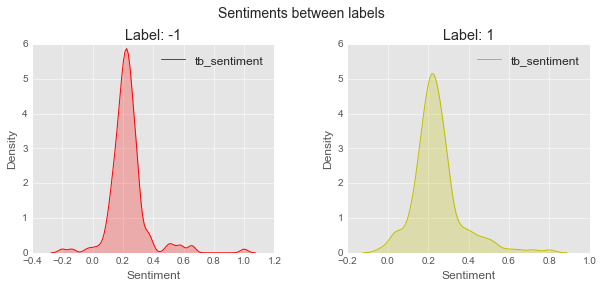

In [438]:
df_neg_1 = df5[df5['labels'] == -1]
df_pos_1 = df5[df5['labels'] == 1 ]
fig = plt.figure(figsize = (10, 4))
title = fig.suptitle("Sentiments between labels", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Label: -1")
ax1.set_xlabel("Sentiment")
ax1.set_ylabel("Density") 
sns.kdeplot(df_neg_1['tb_sentiment'], ax=ax1, shade=True, color='r')

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("Label: 1")
ax2.set_xlabel("Sentiment")
ax2.set_ylabel("Density") 
sns.kdeplot(df_pos_1['tb_sentiment'], ax=ax2, shade=True, color='y')

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


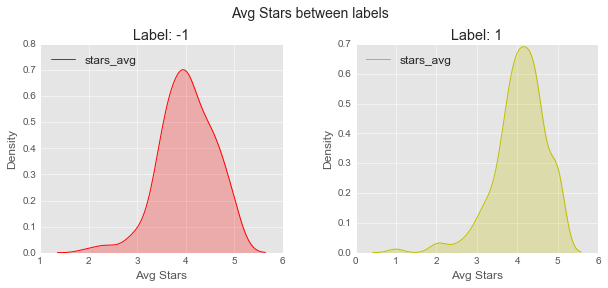

In [439]:
df_neg_1 = df5[df5['labels'] == -1]
df_pos_1 = df5[df5['labels'] == 1 ]
fig = plt.figure(figsize = (10, 4))
title = fig.suptitle("Avg Stars between labels", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Label: -1")
ax1.set_xlabel("Avg Stars")
ax1.set_ylabel("Density") 
sns.kdeplot(df_neg_1['stars_avg'], ax=ax1, shade=True, color='r')

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("Label: 1")
ax2.set_xlabel("Avg Stars")
ax2.set_ylabel("Density") 
sns.kdeplot(df_pos_1['stars_avg'], ax=ax2, shade=True, color='y')

In [394]:
df6 = df5.copy()
df6['labels'] = df6['labels'].apply(lambda x: str(x))

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


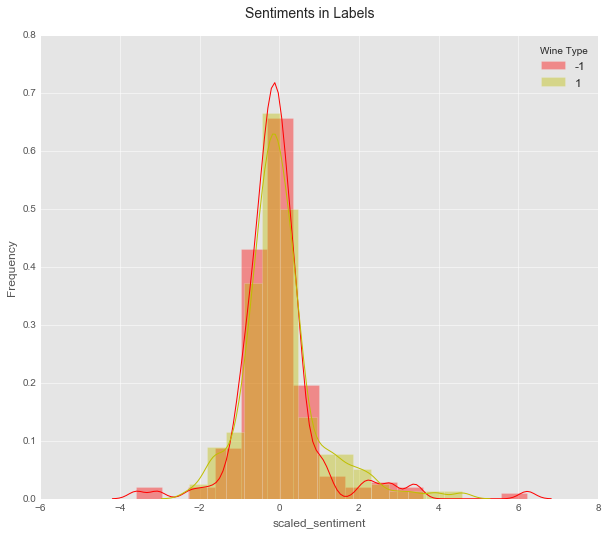

In [415]:
fig = plt.figure(figsize = (10, 8))
title = fig.suptitle("Sentiments in Labels", fontsize=14)
fig.subplots_adjust(top=0.93, wspace=0.3)

ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Sentiments")
ax.set_ylabel("Frequency") 

g = sns.FacetGrid(df6[['scaled_sentiment', 'labels']], hue='labels', palette={"-1": "r", "1": "y"})
g.map(sns.distplot, 'scaled_sentiment', kde=True, bins=15, ax=ax)
ax.legend(title='Wine Type')
plt.close(2)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


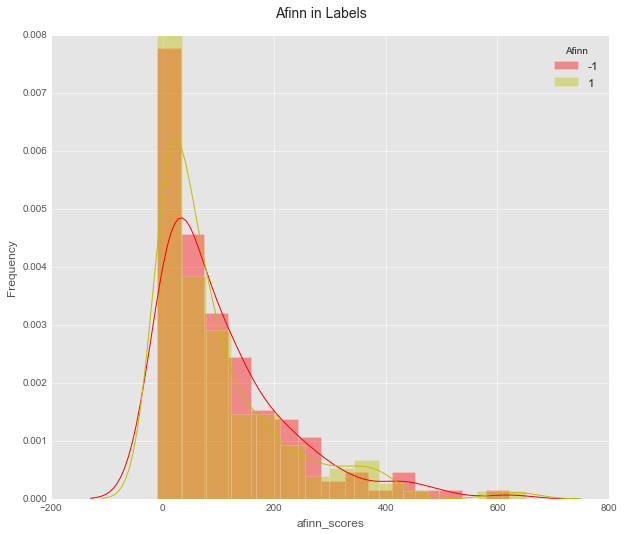

In [416]:
fig = plt.figure(figsize = (10, 8))
title = fig.suptitle("Afinn in Labels", fontsize=14)
fig.subplots_adjust(top=0.93, wspace=0.3)

ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Afinn")
ax.set_ylabel("Frequency") 

g = sns.FacetGrid(df6[['afinn_scores', 'labels']], hue='labels', palette={"-1": "r", "1": "y"})
g.map(sns.distplot, 'afinn_scores', kde=True, bins=15, ax=ax)
ax.legend(title='Afinn')
plt.close(2)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


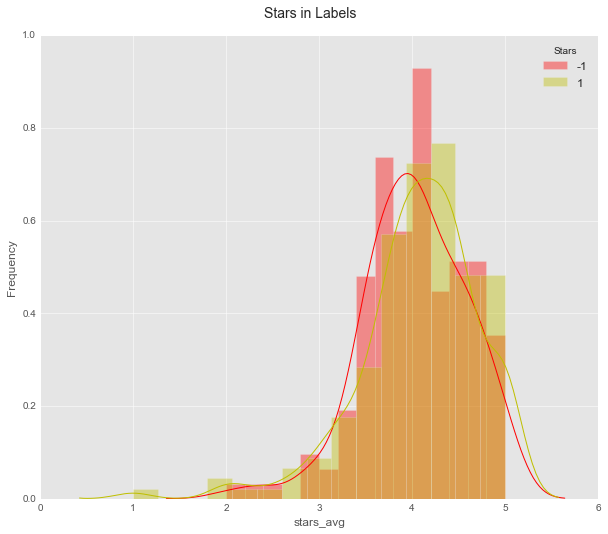

In [417]:
fig = plt.figure(figsize = (10, 8))
title = fig.suptitle("Stars in Labels", fontsize=14)
fig.subplots_adjust(top=0.93, wspace=0.3)

ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Stars")
ax.set_ylabel("Frequency") 

g = sns.FacetGrid(df6[['stars_avg', 'labels']], hue='labels', palette={"-1": "r", "1": "y"})
g.map(sns.distplot, 'stars_avg', kde=True, bins=15, ax=ax)
ax.legend(title='Stars')
plt.close(2)

[<matplotlib.lines.Line2D at 0x1a27c88b38>]

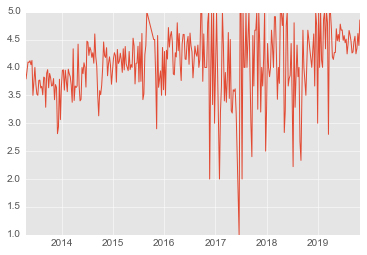

In [418]:
plt.plot(df5['Start_week'], df5['stars_avg'])

[<matplotlib.lines.Line2D at 0x1a2c32ae80>]

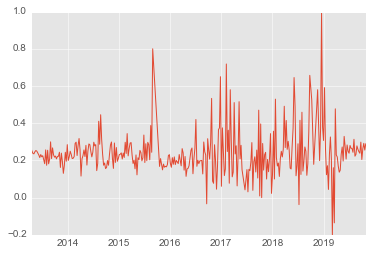

In [419]:
plt.plot(df5['Start_week'], df5['tb_sentiment'])

[<matplotlib.lines.Line2D at 0x1a2c340208>]

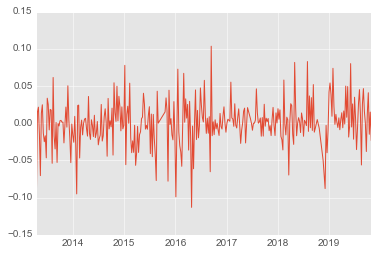

In [420]:
plt.plot(df5['Start_week'], df5['log_returns'])

[<matplotlib.lines.Line2D at 0x1a2c35b588>]

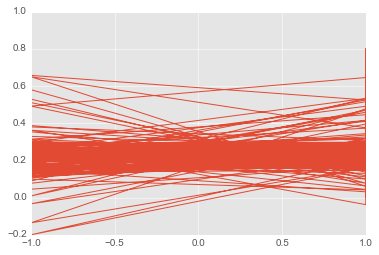

In [421]:
plt.plot(df5['labels'], df5['tb_sentiment'])

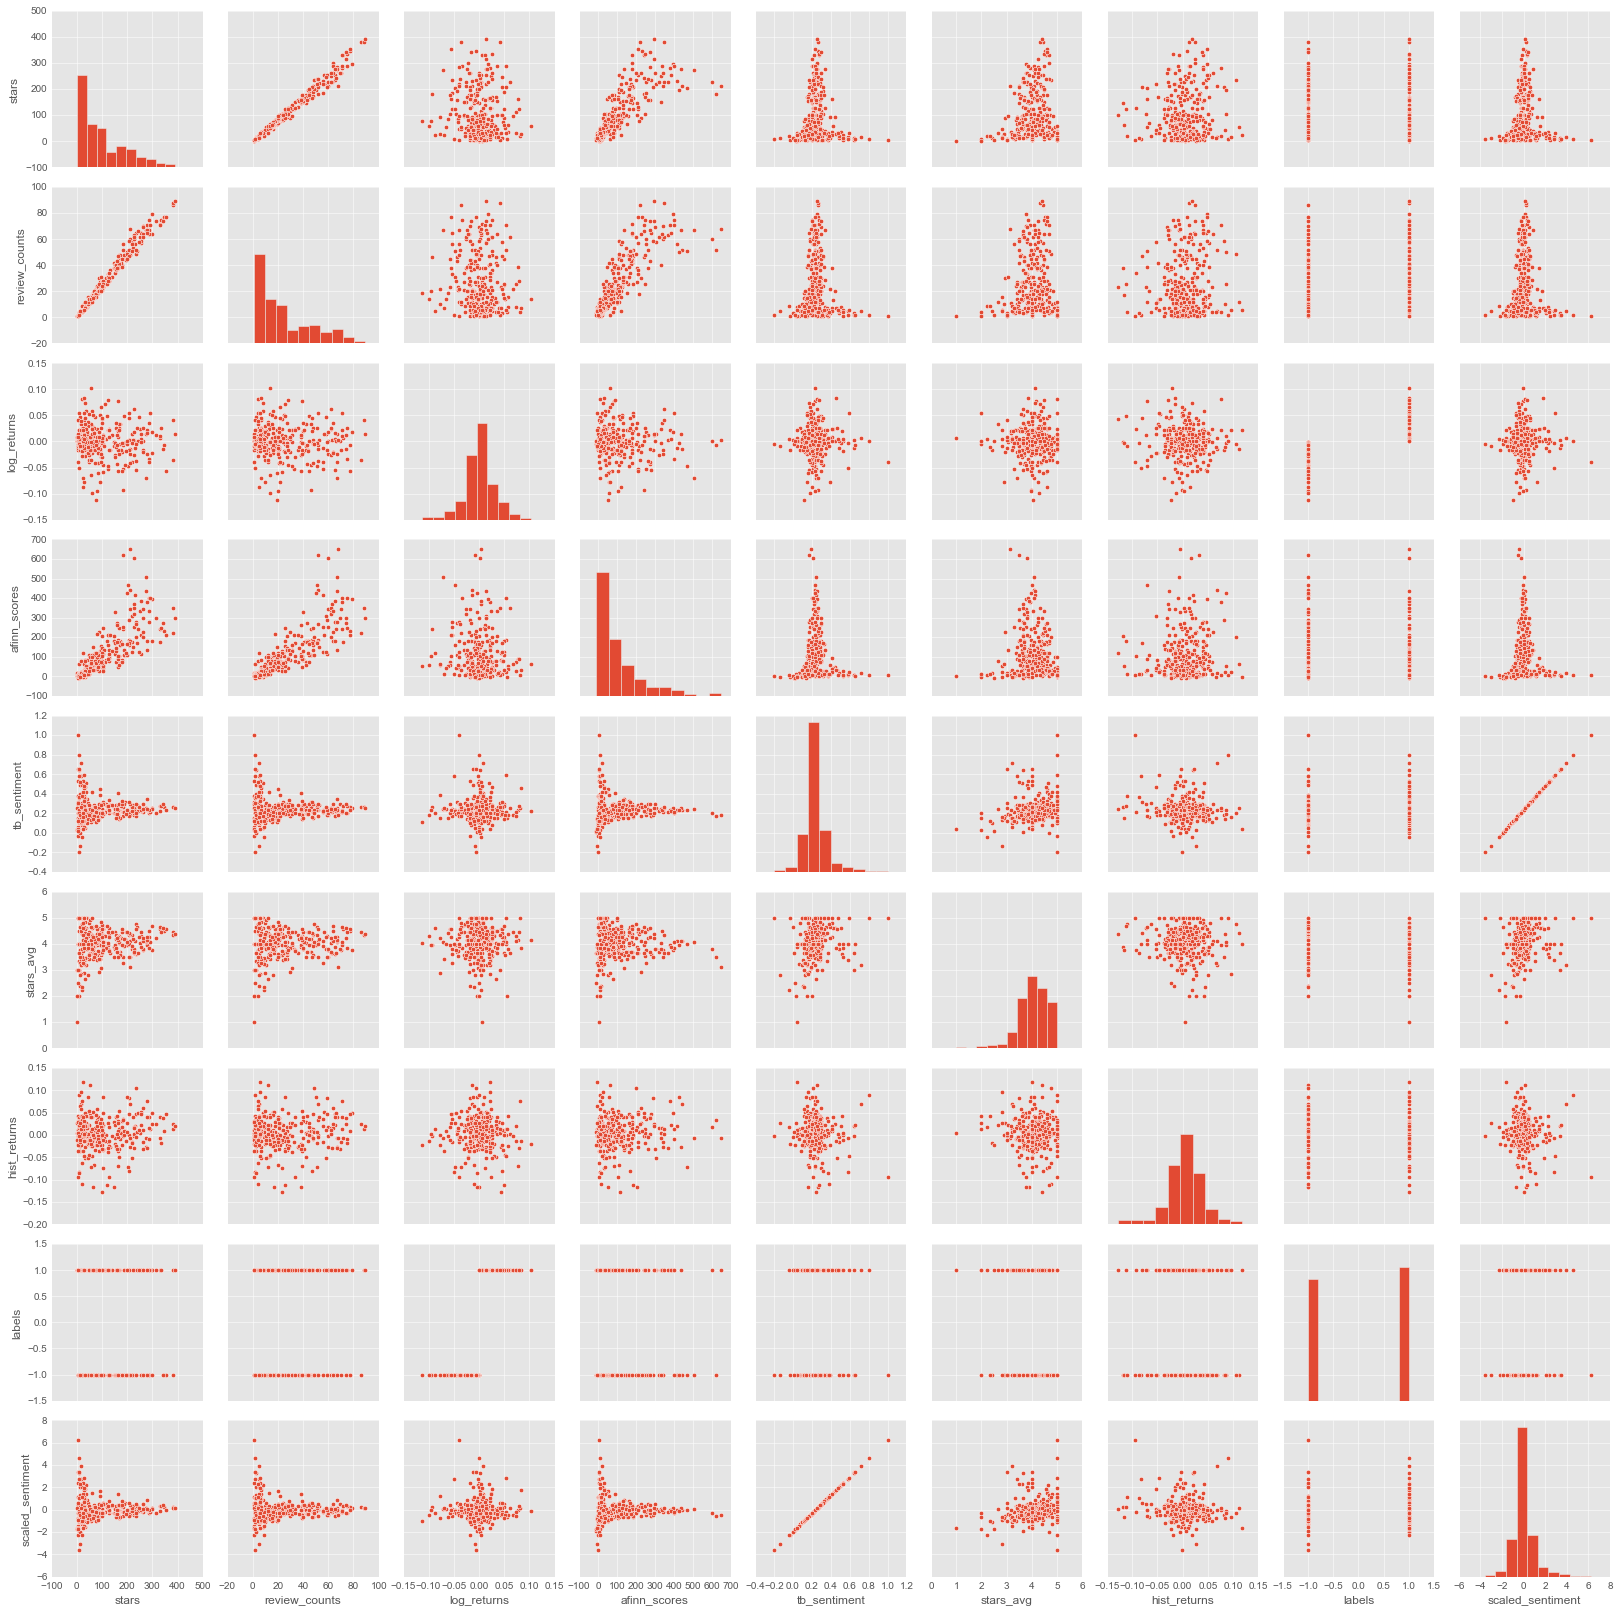

In [422]:
sns.pairplot(df5[['Start_week', 'stars', 'review_counts', 'log_returns',
       'review_body_lemm', 'review_body_lem', 'afinn_scores', 'tb_sentiment',
       'stars_avg', 'hist_returns', 'labels', 'scaled_sentiment']])

[<matplotlib.lines.Line2D at 0x1b0e412a58>]

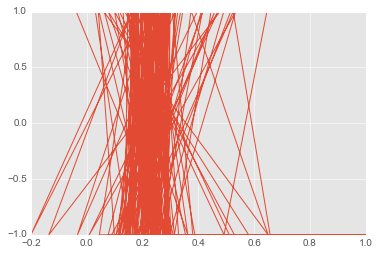

In [423]:
plt.plot(df5['tb_sentiment'],df5['labels'])

In [130]:
df5.columns

Index(['Start_week', 'stars', 'review_body', 'review_counts', 'log_returns',
       'review_body_lemm', 'review_body_lem', 'afinn_scores', 'tb_sentiment',
       'stars_avg', 'hist_returns', 'sentiments_v_neg', 'sentiments_v_neu',
       'sentiments_v_pos', 'sentiments_v_cpd', 'labels', 'scaled_sentiment'],
      dtype='object')

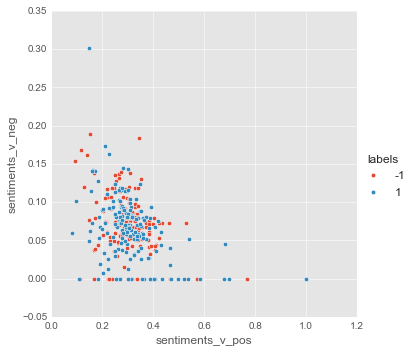

In [440]:
sns.pairplot(x_vars=['sentiments_v_pos'], y_vars=['sentiments_v_neg'], 
             data=df5, hue="labels", size=5)

In [99]:
df5_copy = df5.copy()
df5_copy['Start_week']= pd.to_datetime(df5['Start_week']) 

In [259]:
df_weekly.head()

,Start_week,stars,review_body,review_counts,log_returns,hist_returns,review_body_lemm,review_body_lem,afinn_scores,tb_sentiment,stars_avg,sentiments_vadar,sentiments_v_neg,sentiments_v_neu,sentiments_v_pos,sentiments_v_cpd
0,2013-04-15,182,this is terrible I ordered this months ago and...,46,-0.093022,-0.001735,"[terrible, order, ago, one, side, work, questi...",terrible order ago one side work question whet...,243.0,0.264229,3.956522,"{'neg': 0.073, 'neu': 0.555, 'pos': 0.372, 'co...",0.073,0.555,0.372,0.9999
1,2013-04-22,220,Hi I am interested in the article but I need t...,58,0.014933,-0.051763,"[interest, article, but, need, know, factory, ...",interest article but need know factory unlock ...,307.0,0.250434,3.793103,"{'neg': 0.06, 'neu': 0.583, 'pos': 0.357, 'com...",0.06,0.583,0.357,1
2,2013-04-29,280,i love my new iphone i used to have the model ...,71,0.021573,0.075930,"[love, new, use, model, but, one, far, better,...",love new use model but one far better recommen...,382.0,0.237667,3.943662,"{'neg': 0.079, 'neu': 0.607, 'pos': 0.313, 'co...",0.079,0.607,0.313,1
3,2013-05-06,213,Until now this has been the best purchase I ha...,52,-0.014245,0.068705,"[until, now, best, purchase, make, because, ph...",until now best purchase make because phone gre...,443.0,0.235199,4.096154,"{'neg': 0.063, 'neu': 0.598, 'pos': 0.339, 'co...",0.063,0.598,0.339,1
4,2013-05-13,274,I really like this phone also do not have what...,67,-0.070461,-0.006446,"[really, like, phone, also, what, problem, ver...",really like phone also what problem very good ...,509.0,0.246272,4.089552,"{'neg': 0.058, 'neu': 0.615, 'pos': 0.328, 'co...",0.058,0.615,0.328,1


## Topic Modelling

1. To better understand the reviews 
2. Check if there are significant topics that can be used to further explore


In [255]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

unable to import 'smart_open.gcs', disabling that module


In [260]:
def sent_to_words(sentences):
    '''
    takes in the text and returns a list of cleaned tokens
    '''
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df5.review_body_lem.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['terrible', 'order', 'ago', 'one', 'side', 'work', 'question', 'whether', 'product', 'genuine', 'take', 'forever', 'get', 'here', 'they', 'junk', 'wire', 'one', 'head', 'phone', 'almost', 'cut', 'through', 'way', 'they', 'put', 'case', 'they', 'pour', 'great', 'much', 'better', 'than', 'previous', 'iteration', 'rubber', 'always', 'fell', 'off', 'these', 'fit', 'much', 'better', 'ear', 'far', 'much', 'more', 'durable', 'they', 'bite', 'than', 'like', 'but', 'likely', 'keep', 'them', 'few', 'least', 'worth', 'love', 'product', 'daughter', 'thank', 'you', 'shop', 'recommend', 'fine', 'they', 'great', 'sound', 'work', 'well', 'but', 'they', 'uncomfortable', 'cannot', 'wear', 'them', 'use', 'them', 'they', 'back', 'now', 'wish', 'they', 'buy', 'these', 'when', 'misplace', 'old', 'sturdy', 'pair', 'love', 'very', 'picky', 'about', 'fit', 'well', 'sound', 'quality', 'they', 'look', 'really', 'nice', 'they', 'seem', 'sturdy', 'fit', 'good', 'they', 'don', 'slip', 'out', 'they', 'great', 'wor

In [274]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.002*"optical" + 0.002*"nexus" + 0.001*"element" + 0.001*"removable" + '
  '0.000*"dinky" + 0.000*"conclusion" + 0.000*"protrude" + 0.000*"lollipop" + '
  '0.000*"reiterate" + 0.000*"simplicity"'),
 (1,
  '0.042*"phone" + 0.019*"but" + 0.017*"new" + 0.016*"work" + 0.014*"buy" + '
  '0.012*"get" + 0.012*"come" + 0.011*"great" + 0.010*"from" + 0.010*"good"'),
 (2,
  '0.020*"use" + 0.016*"you" + 0.016*"but" + 0.010*"like" + 0.010*"one" + '
  '0.010*"pencil" + 0.010*"battery" + 0.009*"pro" + 0.009*"can" + 0.008*"get"')]


In [275]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    '''
    takes in the ldamodel, corpus and the texts
    
    Get main topic in each document
    Find the percentage contribution and keywords for each document
    
    return Dominant Topic of text, the percentage of contribution of this text, topic keywords
    '''
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.6799,"phone, but, new, work, buy, get, come, great, from, good","[terrible, order, ago, one, side, work, question, whether, product, genuine, take, forever, get,..."
1,1,1.0,0.6592,"phone, but, new, work, buy, get, come, great, from, good","[interest, article, but, need, know, factory, unlock, because, want, use, operator, good, work, ..."
2,2,1.0,0.4954,"phone, but, new, work, buy, get, come, great, from, good","[love, new, use, model, but, one, far, better, recommend, your, illiterate, mother, call, you, n..."
3,3,2.0,0.5354,"use, you, but, like, one, pencil, battery, pro, can, get","[until, now, best, purchase, make, because, phone, greatly, exceed, want, brand, continue, rest,..."
4,4,1.0,0.5358,"phone, but, new, work, buy, get, come, great, from, good","[really, like, phone, also, what, problem, very, good, look, hope, next, time, can, buy, some, s..."
5,5,1.0,0.6805,"phone, but, new, work, buy, get, come, great, from, good","[love, phone, worth, price, you, regret, buy, phone, all, head, buy, phone, they, say, love, fir..."
6,6,1.0,0.5426,"phone, but, new, work, buy, get, come, great, from, good","[excellent, product, only, come, small, detail, corner, but, important, general, phone, excellen..."
7,7,1.0,0.5964,"phone, but, new, work, buy, get, come, great, from, good","[these, best, head, phone, price, fit, perfectly, they, cause, hurt, get, tire, like, other, old..."
8,8,1.0,0.6141,"phone, but, new, work, buy, get, come, great, from, good","[lose, think, replace, new, one, but, new, one, expensive, think, get, use, one, but, sure, abou..."
9,9,1.0,0.6330,"phone, but, new, work, buy, get, come, great, from, good","[little, too, expensive, because, there, much, difference, but, totally, awesome, how, thin, bat..."


In [276]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,1.0,0.9969,"phone, but, new, work, buy, get, come, great, from, good","[phone, over, month, now, call, morning, see, phone, can, unlock, whether, truly, come, from, no..."
1,2.0,0.9986,"use, you, but, like, one, pencil, battery, pro, can, get","[outstanding, next, generation, mouse, much, better, than, first, version, because, battery, bui..."


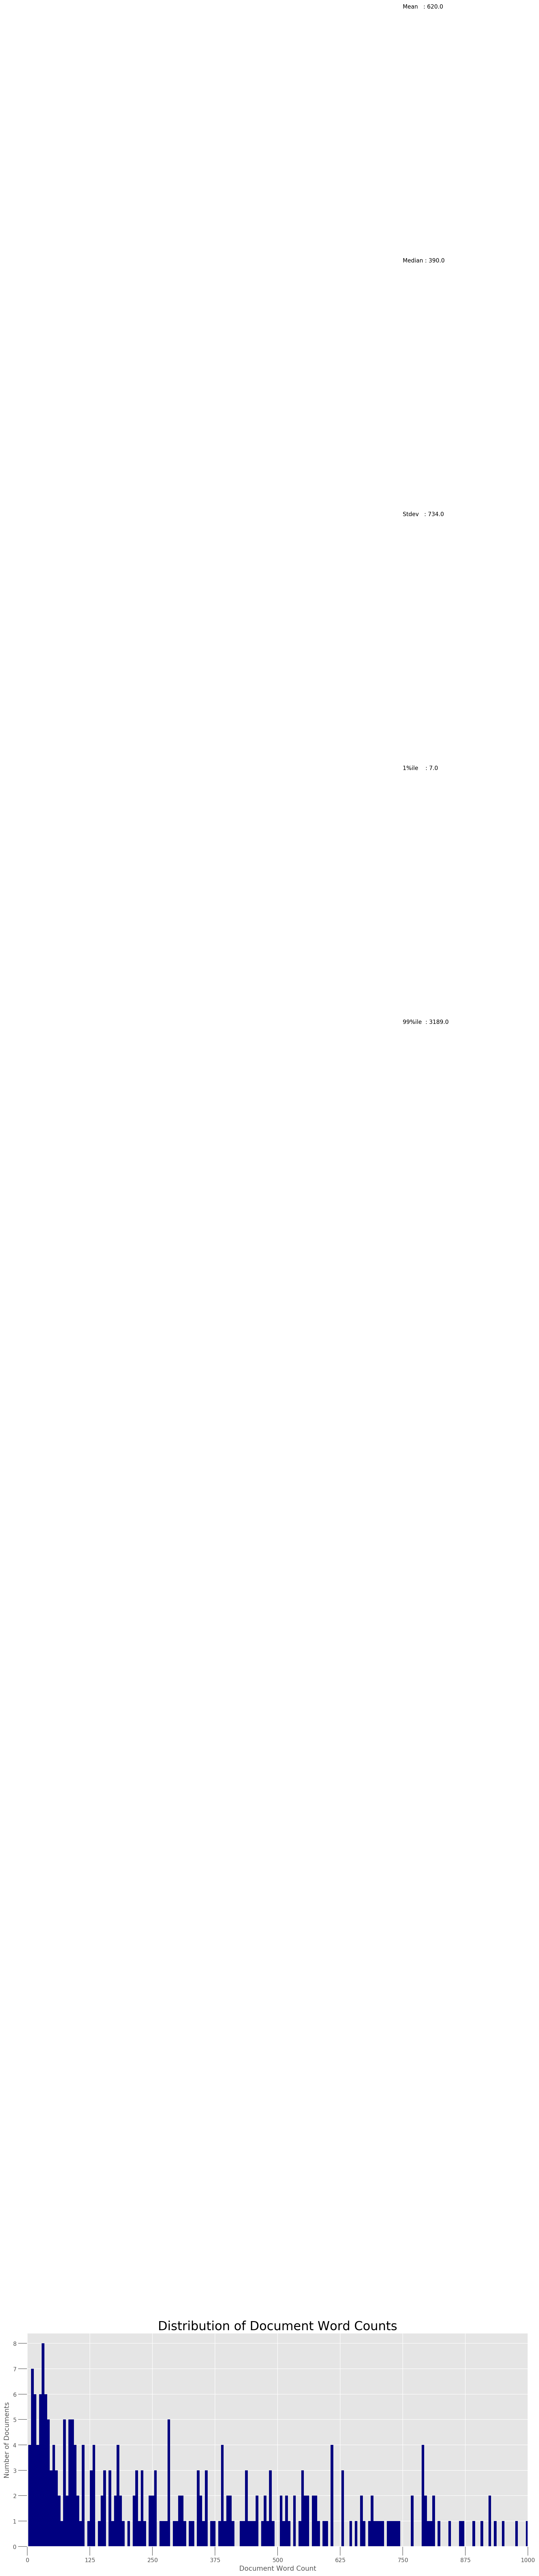

In [277]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

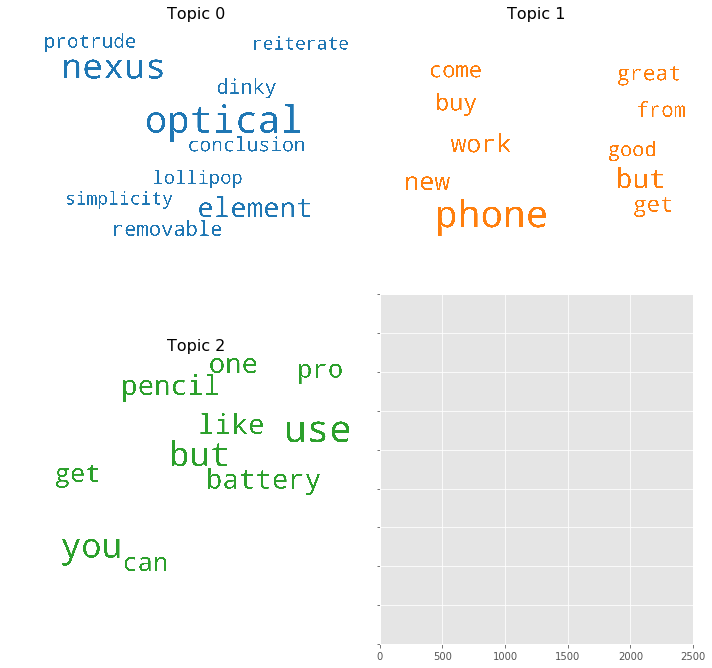

In [280]:
# 1. Wordcloud of Top N words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i == 3: break
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

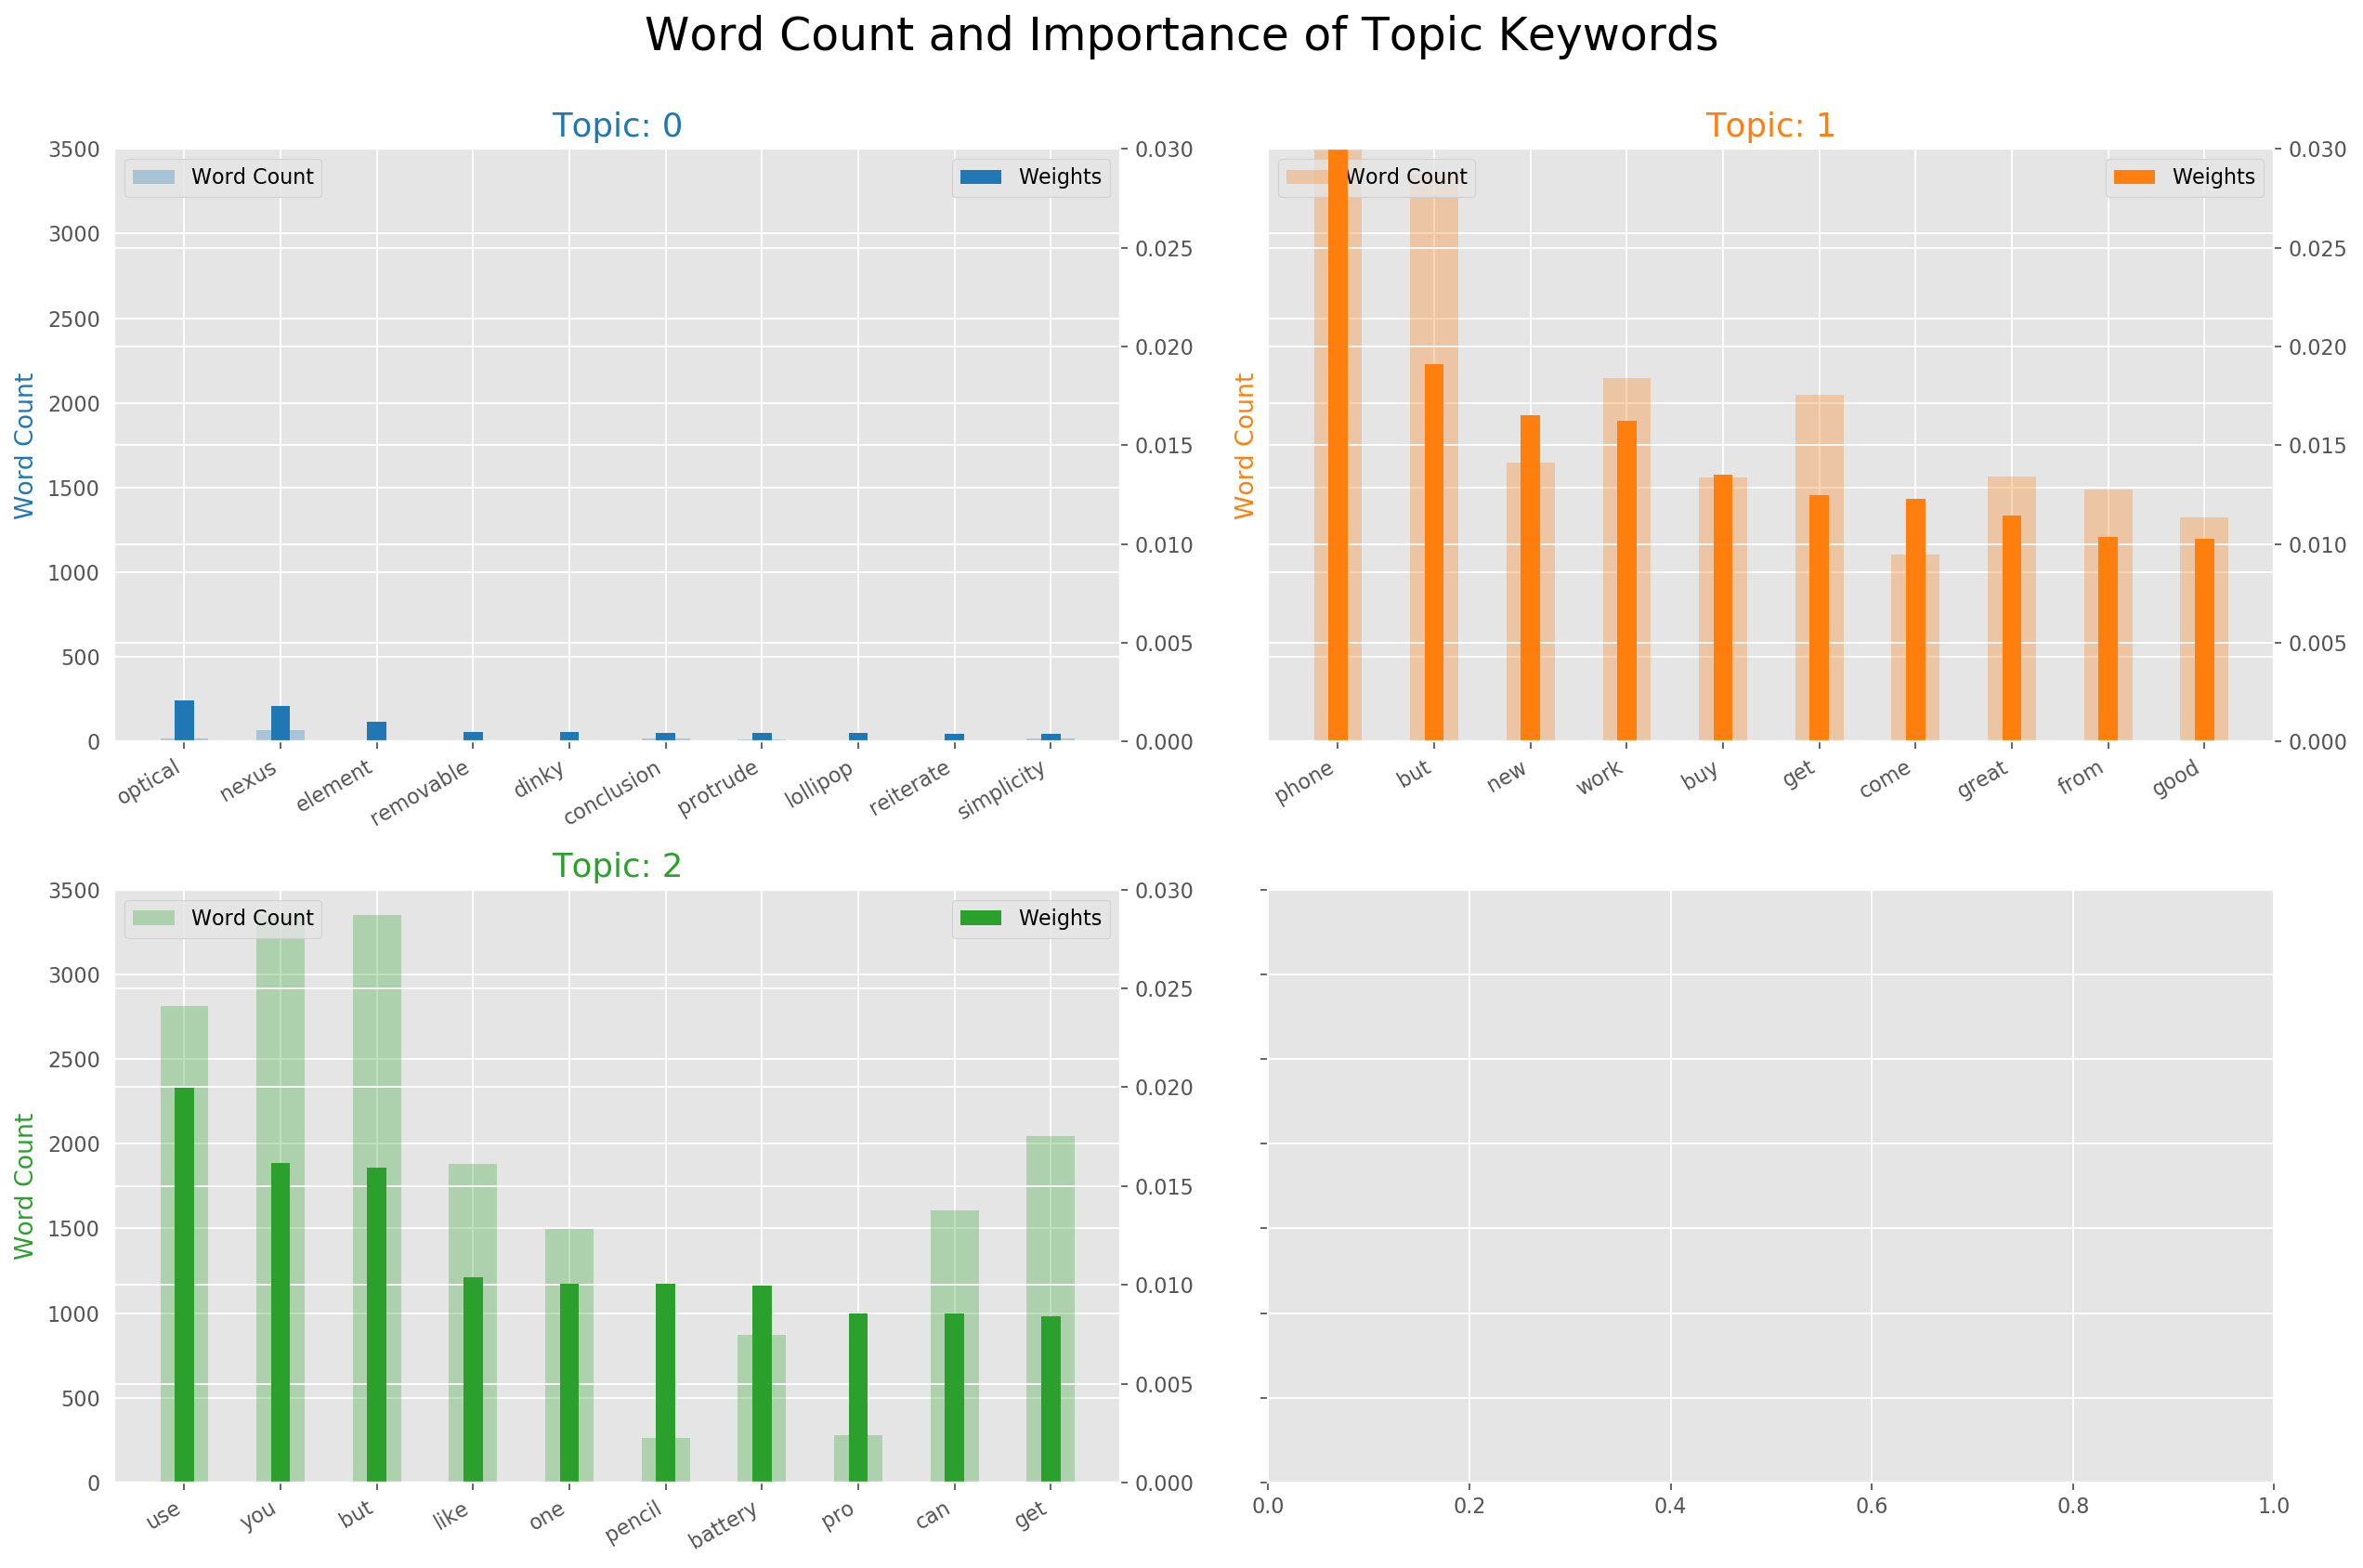

In [281]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    if i == 3: break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [282]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 3
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 327 samples in 0.015s...
[t-SNE] Computed neighbors for 327 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 327 / 327
[t-SNE] Mean sigma: 0.006490
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.034706
[t-SNE] Error after 900 iterations: 0.101363


Loading BokehJS ...

### Interpretation on the Dataset using EDA
1. The words on the wordcloud that were classified between labels = 1 and -1, label = 1 wordcloud show positive sentiment words like love, good, better while the other does not
2. Based on the correlations and plots on various sentiments scores, sentiments of the reviews does not correlate well with both the labels and returns

## Training Models

1. Prepare features and dataset
2. Train various models
3. Get Predictions


In [100]:
# Address Unbalanced data: Oversampling

random.seed(12345)

# Class count
count_class_0, count_class_1 = df5_copy['labels'].value_counts()
df5_copy['labels'].value_counts()
# Divide by class
df_class_neg1 = df5_copy[df5_copy['labels'] == -1]
df_class_1 = df5_copy[df5_copy['labels'] == 1]

# Address unblanced data issue: Oversampling on data samples with rare outputs (which is '-1' in this example)
df_class_neg1_over = df_class_neg1.sample(count_class_0, replace=True, random_state=12345)
df5_copy = pd.concat([df_class_neg1_over, df_class_1], axis=0)

df5_copy['labels'].value_counts()


 1    171
-1    171
Name: labels, dtype: int64

In [101]:
df5_copy.columns
df5_copy['year'] = df5_copy['Start_week'].apply(lambda x: x.year)


In [102]:
df5.columns

Index(['Start_week', 'stars', 'review_body', 'review_counts', 'log_returns',
       'review_body_lemm', 'review_body_lem', 'afinn_scores', 'tb_sentiment',
       'stars_avg', 'hist_returns', 'sentiments_v_neg', 'sentiments_v_neu',
       'sentiments_v_pos', 'sentiments_v_cpd', 'labels', 'scaled_sentiment'],
      dtype='object')

In [425]:
#WEEKLY

#split training and test dataset to 2010 to 2017 and 2018 to 2019 respectively
df5_train = df5_copy[df5_copy['year']<=2017]
df5_test = df5_copy[df5_copy['year']>2017]


def dummy(doc):
    return doc

X_train = df5_train['review_body']
y_train = df5_train['labels']
X_test = df5_test['review_body']
y_test = df5_test['labels']

cv = CountVectorizer(ngram_range=(1, 3), stop_words=None, analyzer="char",min_df = 2, max_df=0.8)


X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)




In [426]:

X_train_dtm = hstack((X_train_cv,np.array(df5_train[['afinn_scores',
       'stars_avg', 'scaled_sentiment', 'hist_returns', 'review_counts']].astype(float))))

X_test_dtm = hstack((X_test_cv,np.array(df5_test[['afinn_scores',
       'stars_avg', 'scaled_sentiment', 'hist_returns', 'review_counts']].astype(float))))



## Bagging

In [287]:
Bagging_clf = BaggingClassifier()
Bagging_clf.fit(X_train_dtm, y_train)
Bagging_pred = Bagging_clf.predict(X_test_dtm)
# Get the training accuracy
print('Training Accuracy: ', metrics.accuracy_score(y_train, Bagging_clf.predict(X_train_dtm)))
# print the accuracy of its predictions
print('Test Accuracy: ', metrics.accuracy_score(y_test, Bagging_pred))
print ("Accuracy: ", accuracy_score(y_test,Bagging_pred))
print ("Sensitivity: ", recall_score(y_test, Bagging_pred))
print ("Precision: ", precision_score(y_test, Bagging_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, Bagging_pred))

Training Accuracy:  0.9795081967213115
Test Accuracy:  0.5
Accuracy:  0.5
Sensitivity:  0.6470588235294118
Precision:  0.515625
ROC AUC Score:  0.49374217772215273


### ADABOOST

In [133]:
param_grid = [
  {'learning_rate': [.2, .5,0.6, .75,0.85, 1]},
  {'n_estimators': [25,40, 50,60, 75, 100]},
]
AdaBoost_clf = GridSearchCV(AdaBoostClassifier(random_state = 12345), param_grid)
AdaBoost_clf.fit(X_train_dtm, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=12345),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'learning_rate': [0.2, 0.5, 0.6, 0.75, 0.85, 1]}, {'n_estimators': [25, 40, 50, 60, 75, 100]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [134]:
AdaBoost_clf.best_score_

0.5040983606557377

In [135]:
AdaBoost_clf.best_params_

{'learning_rate': 0.6}

In [288]:
# Fit Adaboosting Model
AdaBoost_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=9), n_estimators=50, learning_rate = 0.6, random_state=12345)
AdaBoost_clf.fit(X_train_dtm, y_train)
AdaBoost_clf.classes_
# Validation
AdaBoost_pred = AdaBoost_clf.predict(X_test_dtm)

In [408]:
# Get the training accuracy
from sklearn.metrics import precision_recall_fscore_support
print('Training Accuracy: ', metrics.accuracy_score(y_train, AdaBoost_clf.predict(X_train_dtm)))
# print the accuracy of its predictions
print('Test Accuracy: ', metrics.accuracy_score(y_test, AdaBoost_pred))
print ("Accuracy: ", accuracy_score(y_test,AdaBoost_pred))
print ("Sensitivity: ", recall_score(y_test, AdaBoost_pred))
print ("Precision: ", precision_score(y_test, AdaBoost_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, AdaBoost_pred))
print('F1 Score: ', f1_score(y_test, AdaBoost_pred))

Training Accuracy:  1.0
Test Accuracy:  0.5510204081632653
Accuracy:  0.5510204081632653
Sensitivity:  0.7647058823529411
Precision:  0.5492957746478874
ROC AUC Score:  0.5419274092615769
F1 Score:  0.6393442622950819


## Random Forest Fine Tuning

In [161]:
rf_params = {"n_estimators": [50, 100], "criterion": ["gini", "entropy"], "max_depth": [10, 20], "max_features": ["sqrt", "log2"]}
rf =RandomForestClassifier(random_state=111)

In [42]:
rf_clf = GridSearchCV(rf, rf_params)
rf_clf.fit(X_train_dtm, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=111, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 20], 'max_features': ['sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [43]:
rf_clf.best_score_

0.516260162601626

In [44]:
rf_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'log2',
 'n_estimators': 50}

In [409]:
rf_clf = RandomForestClassifier(random_state=111, criterion="entropy", max_depth=20, max_features = "log2", n_estimators=50)
rf_clf.fit(X_train_dtm, y_train)
RF_pred = rf_clf.predict(X_test_dtm)
# Get the training accuracy
print('Training Accuracy: ', metrics.accuracy_score(y_train, rf_clf.predict(X_train_dtm)))
# print the accuracy of its predictions
print('Test Accuracy: ', metrics.accuracy_score(y_test, RF_pred))
print ("Accuracy: ", accuracy_score(y_test,RF_pred))
print ("Sensitivity: ", recall_score(y_test, RF_pred))
print ("Precision: ", precision_score(y_test, RF_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, RF_pred))
print('F1 Score: ', f1_score(y_test, RF_pred))

Training Accuracy:  0.9959016393442623
Test Accuracy:  0.5306122448979592
Accuracy:  0.5306122448979592
Sensitivity:  0.8431372549019608
Precision:  0.5308641975308642
ROC AUC Score:  0.5173133083020443
F1 Score:  0.6515151515151516


## Log Reg fine tuning

In [32]:
logreg_params = {"penalty": ["l1", 'l2'], "fit_intercept": [True, False], "solver": ["saga"], "max_iter": [50, 100, 150]}


In [33]:
lr = LogisticRegression(random_state=111)

In [37]:
lr_clf = GridSearchCV(lr, logreg_params)
lr_clf.fit(X_train_dtm, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=111, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'fit_intercept': [True, False], 'solver': ['saga'], 'max_iter': [50, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [38]:
lr_clf.best_score_

0.4065040650406504

In [39]:
lr_clf.best_params_

{'fit_intercept': True, 'max_iter': 150, 'penalty': 'l2', 'solver': 'saga'}

In [410]:
LogReg_clf= LogisticRegression(random_state=111, fit_intercept=True, max_iter=150, penalty="l2", solver="saga")
LogReg_clf.fit(X_train_dtm, y_train)
logreg_pred = LogReg_clf.predict(X_test_dtm)
# Get the training accuracy
print('Training Accuracy: ', metrics.accuracy_score(y_train, LogReg_clf.predict(X_train_dtm)))
# print the accuracy of its predictions
print('Test Accuracy: ', metrics.accuracy_score(y_test, logreg_pred))
print ("Sensitivity: ", recall_score(y_test, logreg_pred))
print ("Precision: ", precision_score(y_test, logreg_pred))
print('F1 Score: ', f1_score(y_test, logreg_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, logreg_pred))
print("R2 Score: ", r2_score(y_test, logreg_pred))

Training Accuracy:  0.8770491803278688
Test Accuracy:  0.5204081632653061
Sensitivity:  0.6862745098039216
Precision:  0.5303030303030303
F1 Score:  0.5982905982905983
ROC AUC Score:  0.5133500208594076
R2 Score:  -0.92156862745098


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## XGBOOST fine tuning

In [21]:
xgb_params = {"max_depth": [50, 100], "min_child_weight": [10, 20], "reg_alpha": [0.01, 0.001], "reg_lamba": [0.01, 0.001]}

In [24]:
xgb = XGBClassifier(random_state=111)

In [26]:
xgb_clf = GridSearchCV(xgb, xgb_params)
xgb_clf.fit(X_train_dtm, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=111, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [50, 100], 'min_child_weight': [10, 20], 'reg_alpha': [0.01, 0.001], 'reg_lamba': [0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [27]:
xgb_clf.best_score_

0.4715447154471545

In [30]:
xgb_clf.best_params_

{'max_depth': 50, 'min_child_weight': 10, 'reg_alpha': 0.01, 'reg_lamba': 0.01}

In [411]:
xgb_model = XGBClassifier(random_state=111, max_depth=50, min_child_weight=10, reg_alpha=0.01, reg_lambda = 0.01)
xgb_model.fit(X_train_dtm, y_train)

xgb_pred = xgb_model.predict(X_test_dtm)


print('Test Accuracy: ', metrics.accuracy_score(y_test, xgb_pred))
print ("Accuracy: ", accuracy_score(y_test,xgb_pred))
print ("Sensitivity: ", recall_score(y_test, xgb_pred))
print ("Precision: ", precision_score(y_test, xgb_pred))
print('F1 Score: ', f1_score(y_test, xgb_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, xgb_pred))

Test Accuracy:  0.5918367346938775
Accuracy:  0.5918367346938775
Sensitivity:  0.8235294117647058
Precision:  0.5753424657534246
F1 Score:  0.6774193548387097
ROC AUC Score:  0.5819774718397998


## Use Shap to see features impt

In [218]:
new_columns = df5[['afinn_scores',
       'stars_avg', 'scaled_sentiment', 'hist_returns', 'review_counts']]
new_columns.columns

Index(['afinn_scores', 'stars_avg', 'scaled_sentiment', 'hist_returns',
       'review_counts'],
      dtype='object')

In [219]:
X_test_dtm.shape

(98, 5215)

In [249]:
t0 = time.time()
explainer = shap.TreeExplainer(xgb_model)

shap_values_train = explainer.shap_values(X_test_dtm)
t1 = time.time()
timeit = t1-t0
print('time to compute Shapley values (s):', timeit)

txt_dense_df = pd.DataFrame(X_test_dtm.todense(), columns= cv.get_feature_names()+ list(new_columns.columns))
shap_values_train_df = pd.DataFrame(shap_values_train, columns=txt_dense_df.columns)


shap_values_train_df

shap_sum = np.abs(shap_values_train_df).mean(axis=0)

importance_df = pd.DataFrame([txt_dense_df.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ["column_name", "shap_importance (log-odds)"]
importance_df = importance_df.sort_values('shap_importance (log-odds)', ascending=False)
importance_df['shap_importance (%)'] = importance_df['shap_importance (log-odds)'].apply(lambda x: 100 *x/np.sum(importance_df['shap_importance (log-odds)']))


topN = 20
top20 = importance_df.iloc[0:topN]["column_name"]

print('Cumulative Importance', np.sum(importance_df.iloc[0:topN]["shap_importance (%)"]))

importance_df.iloc[0:topN]


shap_values_imp = shap_values_train_df[top20]
shap_values_imp.head()



shap.initjs()

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values_imp.iloc[0].to_numpy(), 
                txt_dense_df.iloc[0][top20])

time to compute Shapley values (s): 0.2983710765838623
Cumulative Importance 39.656291465088366


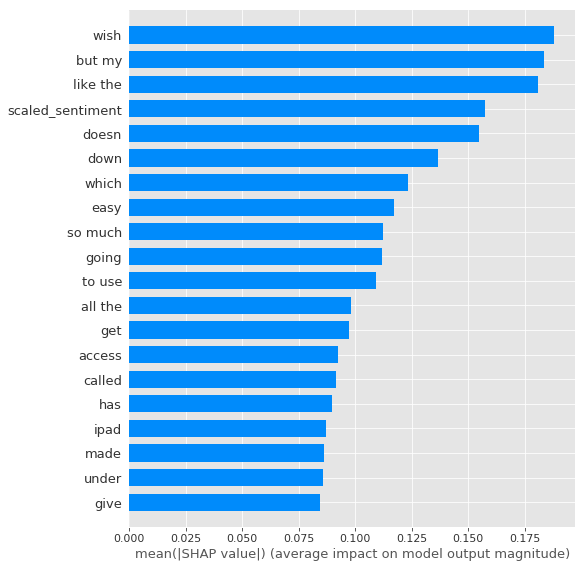

In [252]:
shap.summary_plot(shap_values_train, txt_dense_df,  plot_type="bar")

# Final Model - XGBoost Classifier

1. For the features selected, I tried running with and without weaker correlated sentiments features.
2. The model trained with weaker correlated sentiments features actually have a better performance 
3. We looked into the features importance of XGBoost Classifier as it has the best performance metrics in comparison with the rest of the models.
4. Top 4 important feature goes to scaled sentiments which showed that even though sentiments might be weakly correlated with the returns, there is potential interaction between them which helps to better train the model

## Get Predictions

According to the performance metrics, I chose the final model to churn out the predictions based on the performance of the different models

In [13]:
pred = pd.DataFrame({'Dates':df5['Start_week']})
pred

,Dates
0,2013-04-15
1,2013-04-22
2,2013-04-29
3,2013-05-06
4,2013-05-13
...,...
320,2019-09-30
321,2019-10-07
322,2019-10-14
323,2019-10-21


In [14]:
#Create features
#Fit the reviews text into the CountVectorizer
df5 = df5.sort_values('Start_week')
X = df5['review_body']
X_cv = cv.transform(X)
features = hstack((X_cv,np.array(df5[[ 'afinn_scores',
       'stars_avg','scaled_sentiment', 'hist_returns']].astype(float))))

In [122]:
pred['Predictions'] = list(xgb_model.predict(features))

In [123]:
pred['Predictions'].value_counts()

 1    200
-1    125
Name: Predictions, dtype: int64

In [124]:
pred_dict = pd.Series(pred['Predictions'].values,index=pred['Dates']).to_dict()

In [125]:
pred_dict

{Timestamp('2013-04-15 00:00:00'): -1,
 Timestamp('2013-04-22 00:00:00'): 1,
 Timestamp('2013-04-29 00:00:00'): 1,
 Timestamp('2013-05-06 00:00:00'): -1,
 Timestamp('2013-05-13 00:00:00'): -1,
 Timestamp('2013-05-20 00:00:00'): 1,
 Timestamp('2013-05-27 00:00:00'): 1,
 Timestamp('2013-06-03 00:00:00'): -1,
 Timestamp('2013-06-10 00:00:00'): -1,
 Timestamp('2013-06-17 00:00:00'): -1,
 Timestamp('2013-06-24 00:00:00'): -1,
 Timestamp('2013-07-01 00:00:00'): 1,
 Timestamp('2013-07-08 00:00:00'): 1,
 Timestamp('2013-07-15 00:00:00'): -1,
 Timestamp('2013-07-22 00:00:00'): 1,
 Timestamp('2013-07-29 00:00:00'): 1,
 Timestamp('2013-08-05 00:00:00'): -1,
 Timestamp('2013-08-12 00:00:00'): 1,
 Timestamp('2013-08-19 00:00:00'): -1,
 Timestamp('2013-08-26 00:00:00'): -1,
 Timestamp('2013-09-02 00:00:00'): 1,
 Timestamp('2013-09-09 00:00:00'): -1,
 Timestamp('2013-09-16 00:00:00'): -1,
 Timestamp('2013-09-23 00:00:00'): -1,
 Timestamp('2013-09-30 00:00:00'): 1,
 Timestamp('2013-10-07 00:00:00'): 1

In [126]:
pred
r = pd.date_range('01-01-2010', '12-31-2019')
pred = pred.set_index('Dates').reindex(r).rename_axis('Dates').reset_index()

In [127]:
pred['start week'] = pred.apply(lambda row: row['Dates'] - timedelta(days=row['Dates'].weekday()), axis = 1)

In [128]:
#fill the week with the weekly predictions for daily predictions
#fill predictions to 0 if there are no predictions for that week
pred['Predictions'] = pred['start week'].map(pred_dict)
pred['Predictions'] = pred['Predictions'].fillna(0)

In [129]:
pred_test = pred.copy()

In [131]:
#remove predictions for dates that market is not open
pred_test['Market Dates'] = pred_test['Dates'].apply(lambda x: weekday_check_start_date(x))


In [132]:
pred_test = pred_test[pred_test['Dates']== pred_test['Market Dates']]

In [133]:
del pred_test['Market Dates']
del pred_test['start week']

In [135]:
pred_test['year'] = pred_test['Dates'].apply(lambda x: x.year)
pred_trainset = pred_test[pred_test['year']<=2017]
pred_testset = pred_test[pred_test['year']>2017]


In [136]:
del pred_trainset['year']
del pred_testset['year']

In [ ]:
pred_trainset.to_excel('../../Predictions/Amazon Product AAPL/AAPL_train_AmazonReviews.xlsx')
pred_testset.to_excel('../../Predictions/Amazon Product AAPL/AAPL_test_AmazonReviews.xlsx')